<a href="https://colab.research.google.com/github/willakuffo/accel_iot_data_collection/blob/master/accel_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ACCEL DATA ANALYSIS**
------------------------------------------------
>
> ## [github page](https://github.com/willakuffo/accel_iot_data_collection)

In [ ]:
import pickle
import pandas as pd


## Data description
> The data was collected with the `acceldatacollector.py` script found in the [github](https://github.com/willakuffo/accel_iot_data_collection) repository. 
>
> The data was collected using 2 separate sensors. The **HC-SR04** Ultrasonic sensor and the **MPU6050** .
>
> Each episode is a list of dictionaries whose keys represent the features used for training and prediction.
> The len of the list represents the number of timesteps per episode (The number of datapoints sampled per episode).
> ## `Keys or features`
> -------------------
>`d(travel_dist)` The change in the travel distance calculated from the **HC-SR04**
>
>`x,y,z` The accelerometer readings in the x, y and z direction from the **MPU6050**
>
>`dx,dy,dz` The change accelerometer readings (jerk -->3rd derivative) in the x, y and z direction from the **MPU6050**
>
> `dt` sampled time
>
> `travel_dist` The distance travelled since the beginning of the eposide
> 
>`travel_time` The time taken to travel up to that point

In [ ]:
data = None
with open('data.pickle','rb') as file:
    data = pickle.load(file)

> ### Construct DataFrame from episodes
>
>

In [ ]:
df = pd.DataFrame({}) #initialize dataframe to concat all episodes

#Go through each episode (type dict) and concat to build the entire dataset
for episode in data:
    subdf = pd.DataFrame(episode)
    #print(subdf)
    df = pd.concat([df,subdf]) #concat acccording to columns

df

dx        dy  travel_time  ...         x        dz       v(t)
0  -0.093374 -0.079009     2.371837  ...  2.738967  0.119710  -2.897753
1   0.047884  0.028730     2.473090  ...  2.786851 -0.028730  -7.208371
2  -0.158017  0.179565     2.573853  ...  2.628833  0.059855   7.244803
3   0.131681 -0.165200     2.674714  ...  2.760515 -0.100556   8.724976
4  -0.150835 -0.028730     2.775668  ...  2.609680 -0.069432 -20.207212
..       ...       ...          ...  ...       ...       ...        ...
35  0.033519 -0.031125     5.750833  ...  2.363077  0.684742   6.078196
36 -0.442927 -1.735796     5.860174  ...  1.920150  0.648829  13.718442
37  0.191536  1.077391     5.969007  ...  2.111686 -1.565808   7.810040
38  0.186748 -0.368707     6.077279  ...  2.298434  1.319205   4.340945
39  0.301669  1.058237     6.185200  ...  2.600103 -1.393425  -1.111928

[4000 rows x 11 columns]

>  ## **Functions to draw out episode samples** 
>-------------------------------------------------
> By creating lower triangular matrices of each episode  dataframe and padding the upper part with zeros
>
> Using this, we are able to create more features increasing the resolution of the dataset and making it more robust for real world prediction applications. This may also increase increase the sample size by increasing the rows in the dataset. However this depends on the nature of the dataset.
>
> `NB` One crucial advantage of doing this is that it allows us to create `time sampled features` and `make time sampled predictions`
>
>`Time Sampled Features` are extra features or columns created after the episodes are drawn out. Therefore, a feature or
>
>column `x` which is the acceleration in the x direction will have time sampled features as `xo,x1...xn` which represents the feature x when sampled at time `to,t1...tn` or from time `to --> tn`.
>
>`Time Sampled Predictions` are made using the time sampled features. So if at time `to`, x will have one time sampled feature >`xo` leaving the others to be 0. Therefore at t1, x will have 2 time sampled features `xo,x1` leaving the rest to be 0. >Predictions therefore can be made with any of these scenarios up to the maximum timestep 
>`to...t39` for `xo...x39`. This represents the 40 timesteps per episode 

In [ ]:

def create_diagonal_padding(series):
  mat_padded = pd.DataFrame({})
  for i in range(1,len(series)+1):
    seriescopy = series.copy()
    seriescopy[i:len(seriescopy)] = 0
    mat_padded = pd.concat([mat_padded,seriescopy],axis = 1)
    new_mat = mat_padded.T


  timekeys = []
  for i in range(len(series)):
    timekeys.append(series.name+str(i))
  new_mat.columns = timekeys
  new_mat.index = range(0,len(series))

  #print(new_mat.head())
  #print(new_mat.tail())
      
  return new_mat
    #print(seriescopy)
    #print(a)


In [ ]:
def remake_df_with_padded(features_to_pad = None, from_original = None, features_to_maintain = None):
  '''rebuild new epsiode dataframe with drawn and padded features'''
  new_df = pd.DataFrame({})
  for feature in features_to_pad:
    padded_mat = create_diagonal_padding(from_original[feature])
    new_df = pd.concat([new_df,padded_mat],axis = 1)
  
  if features_to_maintain != None: 
    for keep in features_to_maintain:
      new_df = pd.concat([new_df,from_original[keep]],axis = 1)
  
  return new_df

In [ ]:
#newDF = remake_df_with_padded(features_to_maintain=['travel_time','travel_dist','v(t)','d(travel_dist)'],features_to_pad= ['x','y','z','dx','dy','dz'],from_original = df)
#newDF = remake_df_with_padded(features_to_pad= ['x','y','z','dx','dy','dz'],from_original = df)

In [ ]:
def get_final_df():
    '''Go through all episodes and rebuild new dataframe with increased features'''
    old_df = pd.DataFrame({})
    i = 1
    for episode in data:
        episode_df = pd.DataFrame(episode)
        newDF = remake_df_with_padded(features_to_maintain=['travel_time','travel_dist','v(t)','d(travel_dist)','dt'],
                                      features_to_pad= ['x','y','z','dx','dy','dz'],from_original = episode_df)
        newDF = pd.concat([old_df,newDF])
        old_df = newDF
        print('build progress:',str(i)+'/'+str(len(data)),'--->',round(100*(i/len(data)),2),'%')
        i +=1
        
    return newDF

In [ ]:
#make new dataset from all episodes
finaldf = get_final_df() 

build progress: 1/100 ---> 1.0 %
build progress: 2/100 ---> 2.0 %
build progress: 3/100 ---> 3.0 %
build progress: 4/100 ---> 4.0 %
build progress: 5/100 ---> 5.0 %
build progress: 6/100 ---> 6.0 %
build progress: 7/100 ---> 7.0 %
build progress: 8/100 ---> 8.0 %
build progress: 9/100 ---> 9.0 %
build progress: 10/100 ---> 10.0 %
build progress: 11/100 ---> 11.0 %
build progress: 12/100 ---> 12.0 %
build progress: 13/100 ---> 13.0 %
build progress: 14/100 ---> 14.0 %
build progress: 15/100 ---> 15.0 %
build progress: 16/100 ---> 16.0 %
build progress: 17/100 ---> 17.0 %
build progress: 18/100 ---> 18.0 %
build progress: 19/100 ---> 19.0 %
build progress: 20/100 ---> 20.0 %
build progress: 21/100 ---> 21.0 %
build progress: 22/100 ---> 22.0 %
build progress: 23/100 ---> 23.0 %
build progress: 24/100 ---> 24.0 %
build progress: 25/100 ---> 25.0 %
build progress: 26/100 ---> 26.0 %
build progress: 27/100 ---> 27.0 %
build progress: 28/100 ---> 28.0 %
build progress: 29/100 ---> 29.0 %
bui

### Resulting Dataframe after drawing out episodes
> Note the time sampled features present 

In [ ]:
finaldf.head()

x0        x1        x2  ...       v(t)  d(travel_dist)        dt
0  2.738967  0.000000  0.000000  ...  -2.897753         -6.8729  2.371803
1  2.738967  2.786851  0.000000  ...  -7.208371         -0.7300  0.101271
2  2.738967  2.786851  2.628833  ...   7.244803          0.7300  0.100762
3  2.738967  2.786851  2.628833  ...   8.724976          0.8800  0.100860
4  2.738967  2.786851  2.628833  ... -20.207212         -2.0400  0.100954

[5 rows x 245 columns]

### The Advantage of increased features
----------------------------------------------
> In hopes of imporving the resolution of the dataset
>
> In the real world application, it allows to test for the robustness of different predictions
> **The Po to P40** time feature prediction
> The time feature prediction makes a prediction depending on which number
of timed features have been filled with actual sampled > > data other than the padded 0s

In [ ]:

#new df with increased features
finaldf.shape

(4000, 245)

In [ ]:
#notice the time sampled features
finaldf.columns

Index(['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9',
       ...
       'dz35', 'dz36', 'dz37', 'dz38', 'dz39', 'travel_time', 'travel_dist',
       'v(t)', 'd(travel_dist)', 'dt'],
      dtype='object', length=245)

In [ ]:
# separate input and output features

X = finaldf.copy().drop(['v(t)','travel_dist','d(travel_dist)'],axis = 1)
#Y = finaldf[['v(t)','travel_dist']]
Y = finaldf[['travel_dist']]

In [ ]:
X.head()

x0        x1        x2        x3  ...  dz38  dz39  travel_time        dt
0  2.738967  0.000000  0.000000  0.000000  ...   0.0   0.0     2.371837  2.371803
1  2.738967  2.786851  0.000000  0.000000  ...   0.0   0.0     2.473090  0.101271
2  2.738967  2.786851  2.628833  0.000000  ...   0.0   0.0     2.573853  0.100762
3  2.738967  2.786851  2.628833  2.760515  ...   0.0   0.0     2.674714  0.100860
4  2.738967  2.786851  2.628833  2.760515  ...   0.0   0.0     2.775668  0.100954

[5 rows x 242 columns]

In [ ]:
# Y is what we want to predict. These are trusted values from the Ultrasonic sensor which is to be mapped as an output to the input
finaldf[['travel_dist','v(t)']].head(40)

travel_dist        v(t)
0       -6.8729   -2.897753
1       -7.6029   -7.208371
2       -6.8729    7.244803
3       -5.9929    8.724976
4       -8.0329  -20.207212
5       -6.4629   13.807959
6       -7.7229  -11.146171
7       -8.0329   -2.741358
8       -6.0229   17.875842
9       -8.0629  -18.098667
10      -6.7729   11.536252
11      -7.7129   -8.443925
12      -8.1129   -3.575455
13      -6.3629   15.513643
14      -7.5429  -10.448041
15      44.2971  481.948960
16      -7.1429 -456.284414
17      -5.8029   11.947120
18      36.3171  393.128498
19      -1.9829 -344.444108
20      -0.2129   16.003479
21       0.5171    6.661841
22      46.0271  437.361150
23       5.6871 -382.539172
24      29.0671  224.624688
25       9.6871 -185.355913
26      10.8371   10.997653
27      45.9771  350.826540
28      14.5271 -281.324014
29      17.4171   28.381430
30      20.8871   31.136049
31      22.6171   15.418662
32      25.2671   23.981155
33      26.3971   10.514932
34      30.2571   35.724876
35      32.5971   22.095561
36      35.6071   28.748454
37      38.1371   24.391991
38      40.0571   18.706782
39      40.8571    7.869349

In [ ]:
#scale/normalize features 

from sklearn.preprocessing import MinMaxScaler

In [ ]:
sc = MinMaxScaler()
Xscaled = sc.fit_transform(X)
Yscaled = sc.fit_transform(Y)


In [ ]:
Yscaled.shape

(4000, 1)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
#split data for training(70%) and testing(30%)
xtrain,xtest,ytrain,ytest = train_test_split(Xscaled,Yscaled,test_size = 0.3)

In [ ]:
xtrain.shape,ytest.shape

((2800, 242), (1200, 1))

In [ ]:
#importations for ML
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.metrics import RootMeanSquaredError

Using TensorFlow backend.


In [ ]:
#define model
model = Sequential()
model.add(Dense(units = xtrain.shape[1],input_dim = xtrain.shape[1],activation = 'relu'))
model.add(Dense(units = 512,activation ='relu' ))
model.add(Dense(units = 256,activation = 'relu'))
model.add(Dense(units = 128,activation = 'relu'))
model.add(Dense(units = 64,activation = 'relu'))
model.add(Dense(units = 32,activation = 'relu'))
model.add(Dense(units = 16,activation = 'relu'))
model.add(Dense(units = 8,activation = 'relu'))
model.add(Dense(units = ytrain.shape[1],activation = 'linear'))
model.compile(optimizer = Adam(learning_rate = 0.001),metrics = ['mse','mae',RootMeanSquaredError()],loss ='mse' )

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 242)               58806     
_________________________________________________________________
dense_2 (Dense)              (None, 512)               124416    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 16)               

In [ ]:
hist = model.fit(xtrain,ytrain,validation_data=(xtest,ytest),epochs = 50,
                callbacks = [ModelCheckpoint(filepath = 'accelmodel.hdf5',
                                            monitor = 'val_root_mean_squared_error',mode = 'min',save_best_only = True)])

Train on 2800 samples, validate on 1200 samples
Epoch 1/50
2800/2800 [==============================] - 1s 456us/step - loss: 0.0354 - mse: 0.0354 - mae: 0.1329 - root_mean_squared_error: 0.1882 - val_loss: 0.0178 - val_mse: 0.0178 - val_mae: 0.0996 - val_root_mean_squared_error: 0.1334
Epoch 2/50
2800/2800 [==============================] - 1s 299us/step - loss: 0.0176 - mse: 0.0176 - mae: 0.1004 - root_mean_squared_error: 0.1328 - val_loss: 0.0139 - val_mse: 0.0139 - val_mae: 0.0873 - val_root_mean_squared_error: 0.1180
Epoch 3/50
2800/2800 [==============================] - 1s 292us/step - loss: 0.0112 - mse: 0.0112 - mae: 0.0789 - root_mean_squared_error: 0.1061 - val_loss: 0.0112 - val_mse: 0.0112 - val_mae: 0.0864 - val_root_mean_squared_error: 0.1059
Epoch 4/50
2800/2800 [==============================] - 1s 285us/step - loss: 0.0086 - mse: 0.0086 - mae: 0.0677 - root_mean_squared_error: 0.0928 - val_loss: 0.0069 - val_mse: 0.0069 - val_mae: 0.0585 - val_root_mean_squared_error:

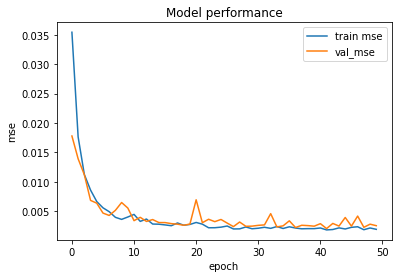

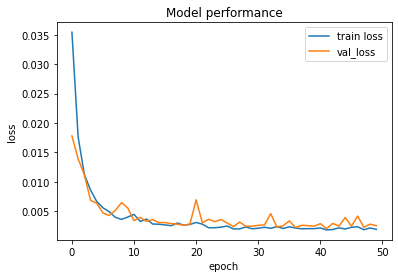

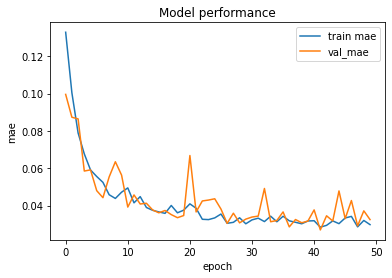

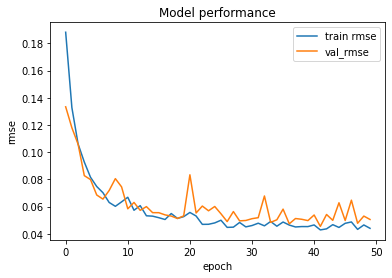

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.title('Model performance')
plt.plot(hist.history['mse'])
plt.plot(hist.history['val_mse'])
plt.legend(['train mse','val_mse'])
plt.xlabel('epoch')
plt.ylabel('mse')
plt.show()

plt.figure()
plt.title('Model performance')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['train loss','val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

plt.figure()
plt.title('Model performance')
plt.plot(hist.history['mae'])
plt.plot(hist.history['val_mae'])
plt.legend(['train mae','val_mae'])
plt.xlabel('epoch')
plt.ylabel('mae')
plt.show()

plt.figure()
plt.title('Model performance')
plt.plot(hist.history['root_mean_squared_error'])
plt.plot(hist.history['val_root_mean_squared_error'])
plt.legend(['train rmse','val_rmse'])
plt.xlabel('epoch')
plt.ylabel('rmse')
plt.show()

In [ ]:
import numpy as np
import time

In [ ]:
#evaluating prediction time
st = time.time()
sc.inverse_transform(model.predict(np.reshape(xtrain[1],(1,-1))))
time.time()-st

0.07564592361450195

# Predictions
> **Training data**

In [ ]:
#pred
actual_travel_train = []
predicted_travel_train = []

actual_velocity_train = []
predicted_velocity_train = []

actual_distance_change_train = []
predicted_distance_change_train = []


for i in range(len(xtrain)):

    actual = sc.inverse_transform(np.reshape(ytrain[i],(1,-1)))
    predicted = sc.inverse_transform(model.predict(np.reshape(xtrain[i],(1,-1))))
    
    #actual_velocity_train.append(actual[0][0])
    #predicted_velocity_train.append(predicted[0][0])
    
    actual_travel_train.append(actual[0][0])
    predicted_travel_train.append(predicted[0][0])
    
    #actual_distance_change_train.append(actual[0][2])
    #predicted_distance_change_train.append(predicted[0][2])
    
    
    print('act dist: ',round(actual[0][0],2),' pred:',round(predicted[0][0],2))#,'       act vel: ',
#          round(actual[0][0],2),' pred: ',round(predicted[0][0],2))
#          ,
#         '      act chng: ',round(actual[0][2],2),' pred:',round(predicted[0][2],2))

    


act dist:  -13.92  pred: -15.8
act dist:  -7.88  pred: -6.31
act dist:  36.78  pred: 33.55
act dist:  31.53  pred: 26.66
act dist:  -111.65  pred: -93.11
act dist:  9.68  pred: -0.71
act dist:  -1.43  pred: -5.85
act dist:  39.22  pred: 29.09
act dist:  -1.89  pred: -2.64
act dist:  -45.39  pred: -43.6
act dist:  7.61  pred: 11.84
act dist:  11.97  pred: 6.15
act dist:  -0.43  pred: -6.6
act dist:  26.3  pred: 20.97
act dist:  31.4  pred: 32.62
act dist:  -1.81  pred: -6.61
act dist:  0.47  pred: -6.4
act dist:  -0.85  pred: -9.06
act dist:  -1.8  pred: -1.78
act dist:  0.87  pred: -5.92
act dist:  -0.31  pred: -3.33
act dist:  -23.21  pred: -27.33
act dist:  8.3  pred: -0.58
act dist:  -3.13  pred: -3.61
act dist:  16.87  pred: 15.66
act dist:  -0.02  pred: -3.87
act dist:  -12.96  pred: -3.18
act dist:  0.12  pred: -3.45
act dist:  -29.82  pred: -37.09
act dist:  -1.73  pred: -7.76
act dist:  12.61  pred: -3.33
act dist:  -21.47  pred: -6.01
act dist:  0.12  pred: -6.34
act dist:  -0

### R2 fit evaluation on training data

In [ ]:
from sklearn.metrics import r2_score


In [ ]:
print('travel fit coefficient          :',r2_score(actual_travel_train,predicted_travel_train))
#print('velocity fit coefficient        :',r2_score(actual_velocity_train,predicted_velocity_train))
#print('distance change fit coefficient :',r2_score(actual_distance_change_train,predicted_distance_change_train))

travel fit coefficient          : 0.9169444553977649


In [ ]:
#visuaizing function
def visualize(title = 'visualization',scope = [0,100],actual_ = None,predicted_ = None):
    plt.style.use('fivethirtyeight')
    #scatter plot
    plt.figure(figsize=(12,8))
    plt.title(title)
    plt.scatter(list(range(len(actual_[scope[0]:scope[1]]))),actual_[scope[0]:scope[1]])
    plt.scatter(list(range(len(predicted_[scope[0]:scope[1]]))),predicted_[scope[0]:scope[1]])

    plt.legend(['ground truth','pred'])
    plt.show()

    #line plot
    plt.figure(figsize=(12,8))
    plt.title(title)
    plt.plot(list(range(len(actual_[scope[0]:scope[1]]))),actual_[scope[0]:scope[1]])
    plt.plot(list(range(len(predicted_[scope[0]:scope[1]]))),predicted_[scope[0]:scope[1]])

    plt.legend(['ground truth','pred'])
    plt.show()

    #scatter actual plot line predicted
    plt.figure(figsize=(12,8))
    plt.title(title)
    plt.scatter(list(range(len(actual_[scope[0]:scope[1]]))),actual_[scope[0]:scope[1]],color = 'b')
    plt.plot(list(range(len(predicted_[scope[0]:scope[1]]))),predicted_[scope[0]:scope[1]],color = 'r')

    plt.legend(['pred','ground truth'])
    plt.show()


# Training fit visualizations
> ## `Travel`

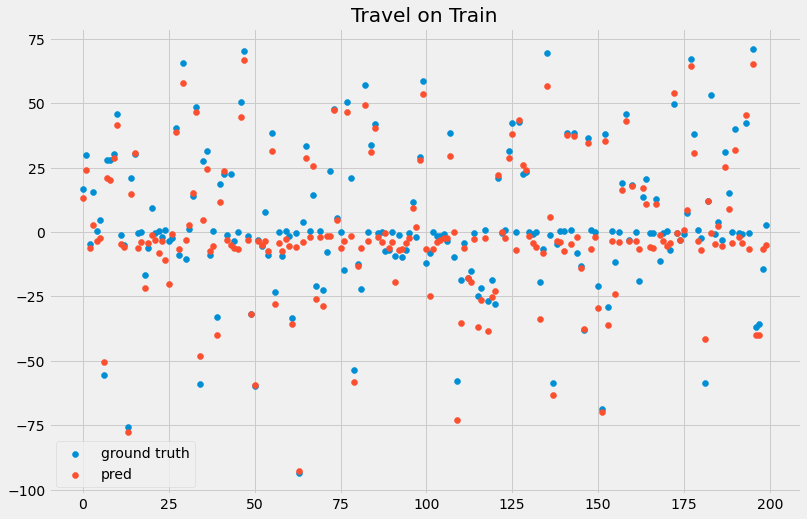

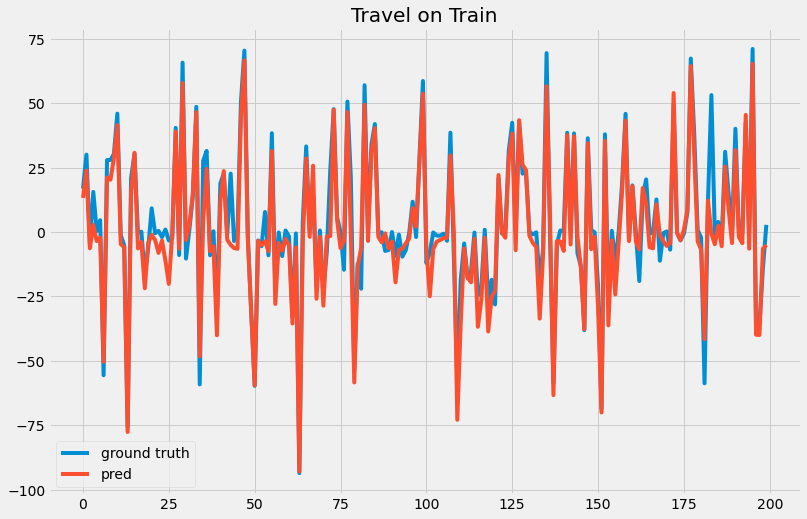

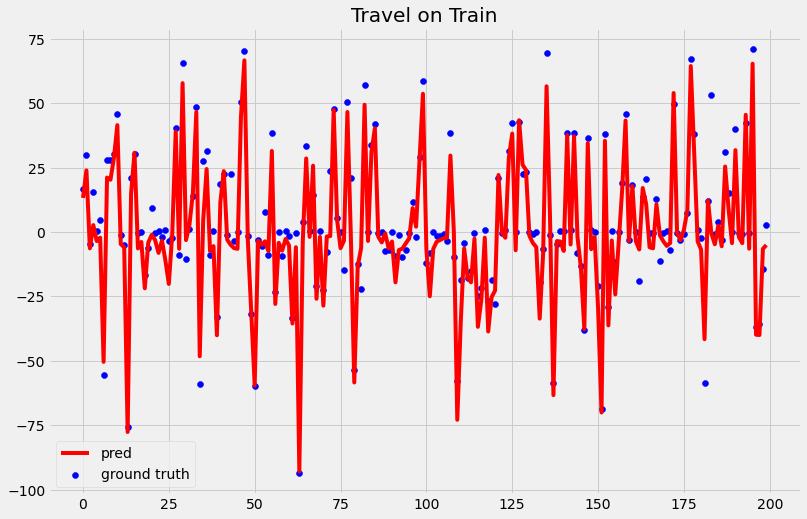

In [ ]:
visualize(title = 'Travel on Train',actual_= actual_travel_train,predicted_=predicted_travel_train,scope = [800,1000])

## `Velocity`

In [ ]:
#visualize(title = 'Velocity on Train',actual_= actual_velocity_train,predicted_=predicted_velocity_train,scope = [800,1000])

## `Travel distance change`

In [ ]:
#visualize(title = 'Distance Change on Train',actual_= actual_distance_change_train,
#          predicted_=predicted_distance_change_train,scope = [800,1000])

> ## Testing data fit visualizations (Unseen data)

In [ ]:
#pred
actual_travel_test = []
predicted_travel_test = []

actual_velocity_test = []
predicted_velocity_test = []

actual_distance_change_test = []
predicted_distance_change_test= []


for i in range(len(xtest)):

    actual = sc.inverse_transform(np.reshape(ytest[i],(1,-1)))
    predicted = sc.inverse_transform(model.predict(np.reshape(xtest[i],(1,-1))))
    
    #actual_velocity_test.append(actual[0][0])
    #predicted_velocity_test.append(predicted[0][0])
    
    actual_travel_test.append(actual[0][0])
    predicted_travel_test.append(predicted[0][0])
    
    #actual_distance_change_test.append(actual[0][2])
    #predicted_distance_change_test.append(predicted[0][2])
    
    
    print('act dist: ',round(actual[0][0],2),' pred:',round(predicted[0][0],2))#,'       act vel: ',
#          round(actual[0][0],2),' pred: ',round(predicted[0][0],2))#,
#         '      act chng: ',round(actual[0][2],2),' pred:',round(predicted[0][2],2))

    

    


act dist:  29.49  pred: 23.34
act dist:  30.2  pred: 29.7
act dist:  -0.37  pred: -1.64
act dist:  -3.22  pred: -6.14
act dist:  -30.86  pred: -30.88
act dist:  13.89  pred: 7.32
act dist:  1.29  pred: -2.67
act dist:  -25.12  pred: -6.49
act dist:  -0.28  pred: -3.73
act dist:  -2.31  pred: -3.85
act dist:  -0.15  pred: -3.8
act dist:  35.83  pred: 31.53
act dist:  -36.02  pred: -35.7
act dist:  38.08  pred: 36.22
act dist:  -11.69  pred: -6.59
act dist:  -13.76  pred: -5.31
act dist:  35.29  pred: 32.44
act dist:  32.77  pred: 24.32
act dist:  -7.35  pred: -3.5
act dist:  -6.84  pred: -5.67
act dist:  -1.12  pred: -3.42
act dist:  -0.6  pred: -2.31
act dist:  28.63  pred: 22.58
act dist:  44.57  pred: 44.21
act dist:  -28.4  pred: -29.38
act dist:  -9.48  pred: -6.25
act dist:  -32.51  pred: -70.89
act dist:  -1.42  pred: -4.22
act dist:  -26.68  pred: -31.45
act dist:  31.71  pred: 24.22
act dist:  9.56  pred: 9.01
act dist:  -29.25  pred: -29.6
act dist:  -0.68  pred: 0.77
act dist

### R2 fit evaluation on test data

In [ ]:
print('travel fit coefficient          :',r2_score(actual_travel_test,predicted_travel_test))
#print('velocity fit coefficient        :',r2_score(actual_velocity_test,predicted_velocity_test))
#print('distance change fit coefficient :',r2_score(actual_distance_change_test,predicted_distance_change_test))

travel fit coefficient          : 0.8787570730504353


## `Travel Visualization` on Test
-----------------------

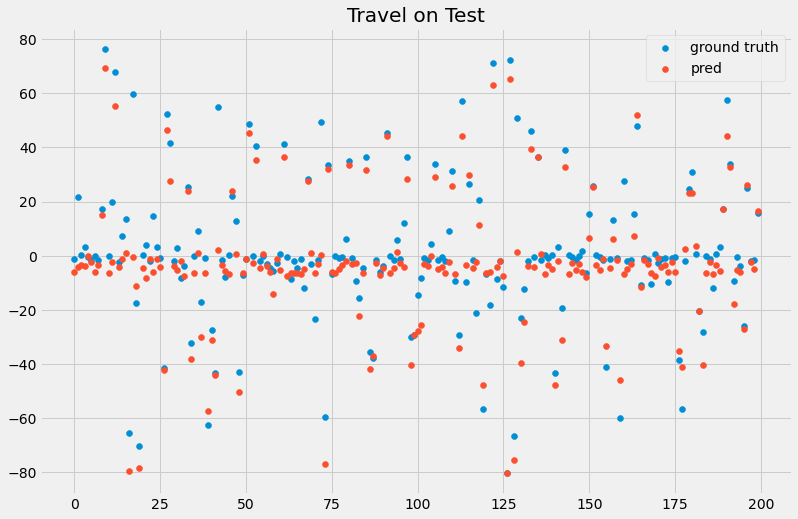

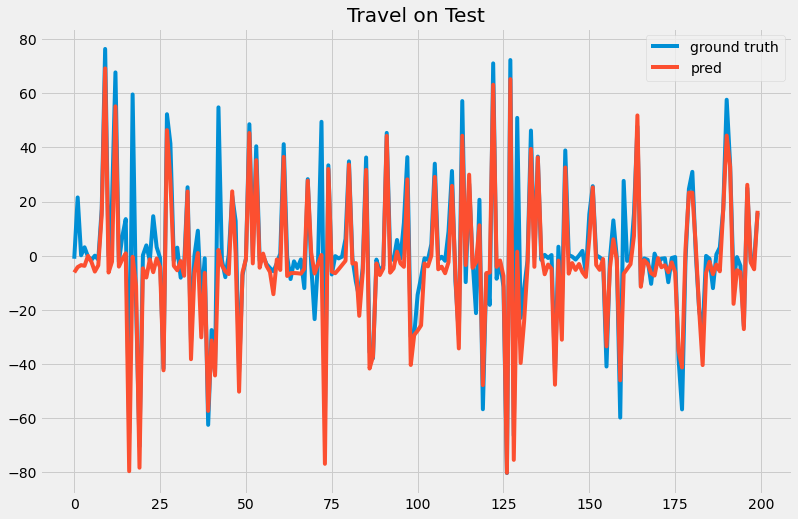

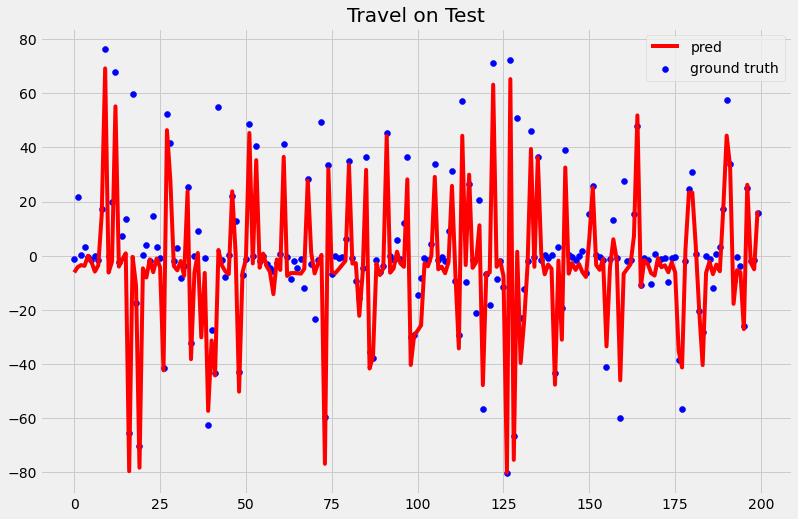

In [ ]:
visualize(title = 'Travel on Test',actual_= actual_travel_test,
          predicted_=predicted_travel_test,scope = [800,1000])

## `Velocity` on Test

In [ ]:
#visualize(title = 'Velocity on Test',actual_= actual_velocity_test,predicted_=predicted_velocity_test,scope = [800,1000])

## `Travel distance change` on Test

In [ ]:
#visualize(title = 'Distance Change on Test',actual_= actual_distance_change_test,
#          predicted_=predicted_distance_change_test,scope = [800,1000])

In [ ]:
train_predictions = sc.inverse_transform(model.predict(xtrain))
train_predictions

array([[-15.801878 ],
       [ -6.3076057],
       [ 33.553703 ],
       ...,
       [ -3.6261296],
       [ -5.268483 ],
       [ -3.0336382]], dtype=float32)

In [ ]:
train_actual = sc.inverse_transform(ytrain)
train_actual

array([[-13.9202],
       [ -7.8826],
       [ 36.7829],
       ...,
       [ -1.7641],
       [-11.579 ],
       [ -0.349 ]])

In [ ]:
'''TEST PREDICTIONS'''

test_predictions = sc.inverse_transform(model.predict(xtest))
test_predictions

array([[23.33611   ],
       [29.69576   ],
       [-1.6434971 ],
       ...,
       [ 0.05331675],
       [25.28368   ],
       [11.545069  ]], dtype=float32)

In [ ]:
test_actual = sc.inverse_transform(ytest)
test_actual

array([[29.4939],
       [30.2029],
       [-0.3705],
       ...,
       [ 9.7247],
       [24.4655],
       [21.2715]])






# !!!======================  Working here  =======================!!!

# Prediction Techniques
> Endeavour to run different kinds of predictions as a result of different time samples features
>
>Po to P40 because there are 40 datapoints were sampled per episode

In [ ]:
#function returns all rows (datapoints) of a particular sampled timed-feature
#dataframe must not be shuffled as it emlpoys the use of the original indices
def getSampleTimedRows(dataframe,sample_timed_feature = 0,samples_per_episode = 40):
    #samples per episode referes to the number of samples
    #sampled per episode when callecting the data

    rows = []
    for i in range(sample_timed_feature,dataframe.shape[0],samples_per_episode):
        rows.append(dataframe.iloc[i])
    return pd.DataFrame(rows)
    
        
    

In [ ]:
def investigate_time_sampled_features():
    
    v_r2 =[] 
    travel_r2 = []
    change_r2 = []
    x = []
    
    for tsf in range(1,41):
        P1 = getSampleTimedRows(finaldf,sample_timed_feature=tsf)


        Xp1 = P1.copy().drop(['v(t)','travel_dist','d(travel_dist)'],axis = 1)
        Yp1 = P1[['travel_dist']]

        Xp1_scaled = sc.fit_transform(Xp1)
        Yp1_scaled = sc.fit_transform(Yp1)
        Xp1_pred = sc.inverse_transform(model.predict(Xp1_scaled))
       
        #v_pred = []
        travel_pred = []
        #t_change_pred = []
        #v_a = []
        travel_a = []
        #t_change_a= []

        for i in Xp1_pred:
           # v_pred.append(i[0])
            travel_pred.append(i[0])
            #t_change_pred.append(i[2])

        for i in np.array(Yp1):
            #v_a.append(i[0])
            travel_a.append(i[0])
            #t_change_a.append(i[2])

        travel_r2.append(r2_score(travel_a,travel_pred))
        #v_r2.append(r2_score(v_a,v_pred))
        #change_r2.append(r2_score(t_change_a,t_change_pred))
        x.append(tsf)
        #print(tsf)
        
    plt.figure(figsize=(10,8))
    plt.plot(x,travel_r2)
    #plt.plot(x,v_r2)
    #plt.plot(x,change_r2)
    plt.xlabel('time sampled feature')
    plt.ylabel('r2_score')
    plt.legend(['travel'])#,'velocity','change'])
    plt.show()
    
    print('Best TIme Sampled Features R2score')
    print('travel        :',max(travel_r2),'     Best Feature: ',travel_r2.index(max(travel_r2))+1)
    #print('velocity      :',max(v_r2),'     Best Feature: ',v_r2.index(max(v_r2))+1)
    #print('travel change :',max(change_r2),'     Best Feature: ',change_r2.index(max(change_r2))+1)

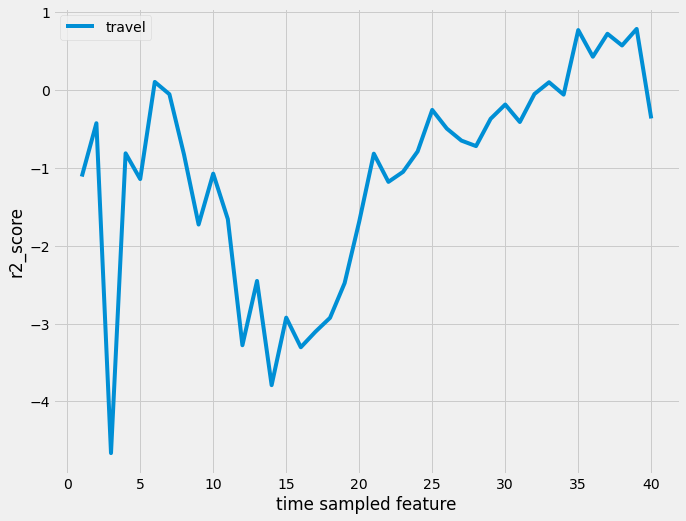

Best TIme Sampled Features R2score
travel        : 0.7847627695744217      Best Feature:  39


In [ ]:
investigate_time_sampled_features()

In [ ]:
X.columns

Index(['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9',
       ...
       'dz32', 'dz33', 'dz34', 'dz35', 'dz36', 'dz37', 'dz38', 'dz39',
       'travel_time', 'dt'],
      dtype='object', length=242)

In [ ]:
'''plt.figure(figsize=(16,10))
plt.title('travel')
plt.plot(list(range(len(travel_a))),travel_a,color = 'r')
plt.plot(list(range(len(travel_pred))),travel_pred)

plt.legend(['gt','pred'])
plt.show()

plt.figure(figsize=(16,10))
plt.title('V')
plt.plot(list(range(len(v_a))),v_a,color = 'r')
plt.plot(list(range(len(v_pred))),v_pred)

plt.legend(['gt','pred'])
plt.show()

plt.figure(figsize=(16,10))
plt.title('C')
plt.plot(list(range(len(t_change_a))),t_change_a,color = 'r')
plt.plot(list(range(len(t_change_pred))),t_change_pred)

plt.legend(['gt','pred'])
plt.show()
'''

"plt.figure(figsize=(16,10))\nplt.title('travel')\nplt.plot(list(range(len(travel_a))),travel_a,color = 'r')\nplt.plot(list(range(len(travel_pred))),travel_pred)\n\nplt.legend(['gt','pred'])\nplt.show()\n\nplt.figure(figsize=(16,10))\nplt.title('V')\nplt.plot(list(range(len(v_a))),v_a,color = 'r')\nplt.plot(list(range(len(v_pred))),v_pred)\n\nplt.legend(['gt','pred'])\nplt.show()\n\nplt.figure(figsize=(16,10))\nplt.title('C')\nplt.plot(list(range(len(t_change_a))),t_change_a,color = 'r')\nplt.plot(list(range(len(t_change_pred))),t_change_pred)\n\nplt.legend(['gt','pred'])\nplt.show()\n"

In [ ]:
#plt.plot(range(0,40),finaldf[40:80]['travel_dist'])

def vis_ep(c,d,title):
    a =sc.fit_transform(X[c:d][list(X.columns)])
    b = sc.fit_transform(np.reshape(np.array(Y['travel_dist']),(-1,1)))
    plt.figure(figsize=(10,8))
    plt.title(title)
    plt.plot(range(c,d),Y[c:d])
    plt.plot(range(c,d),sc.inverse_transform(model.predict(a)))
    plt.legend(['gt','pred'])
    plt.show()

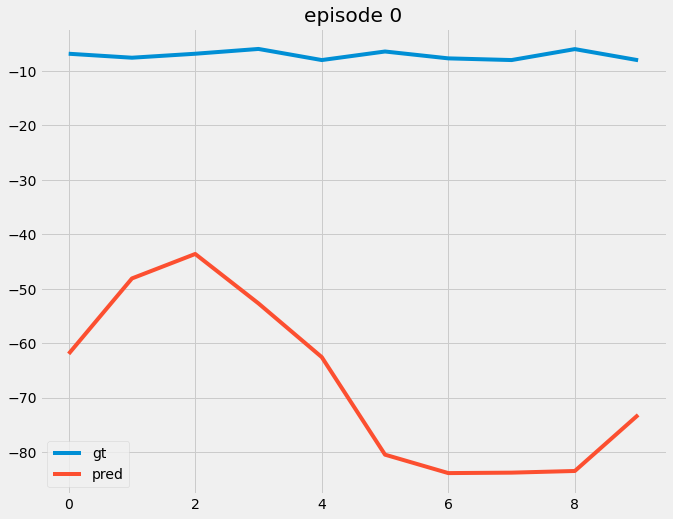

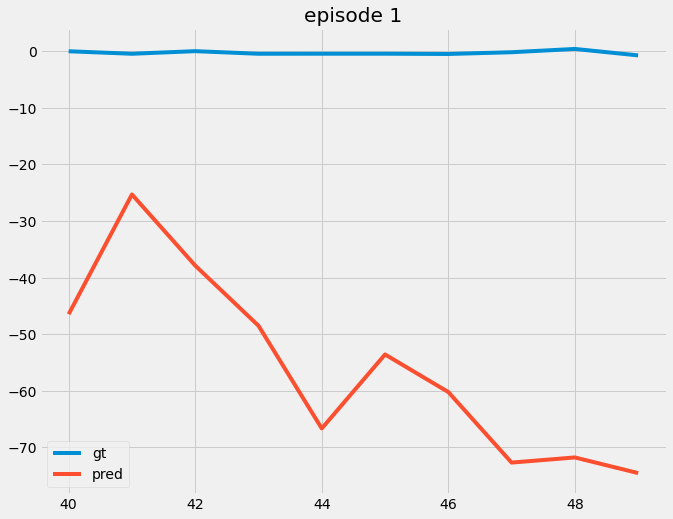

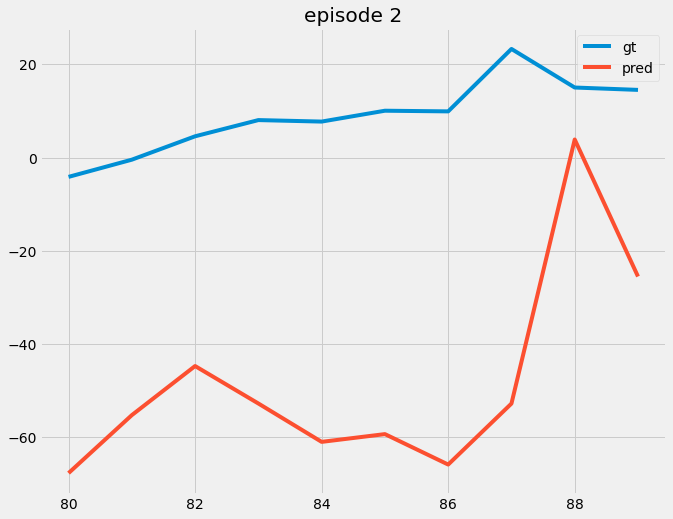

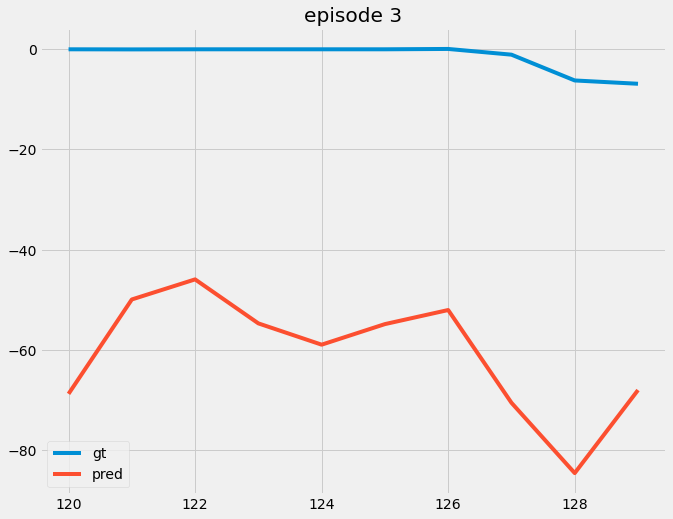

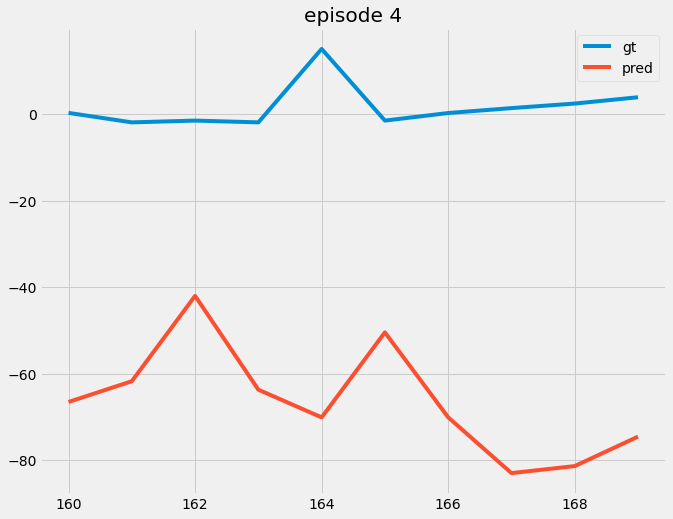

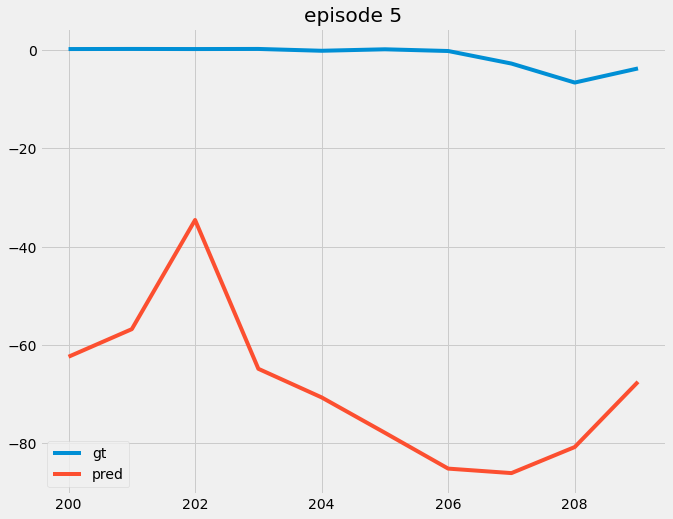

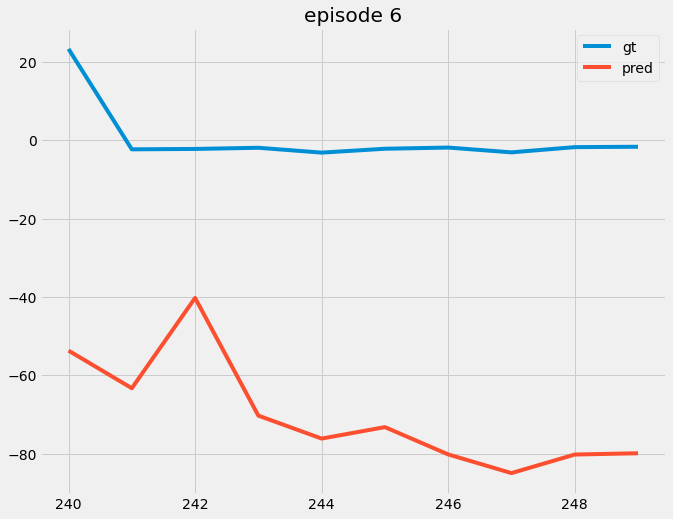

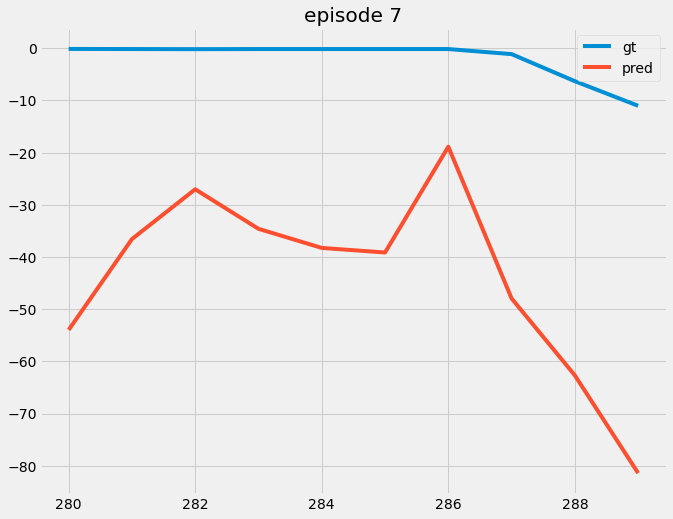

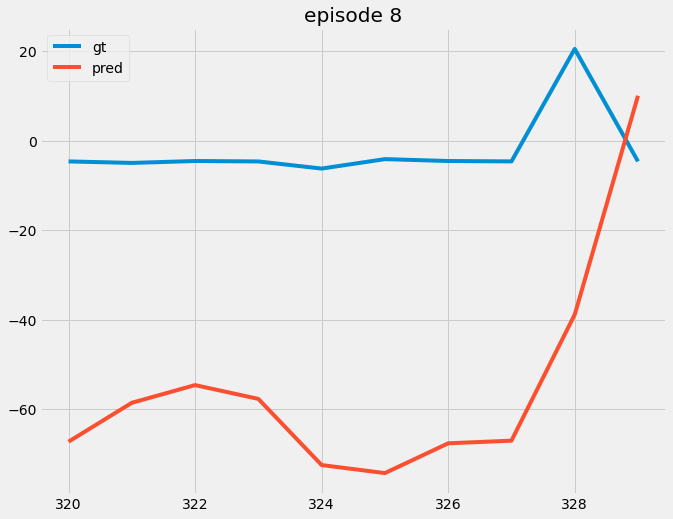

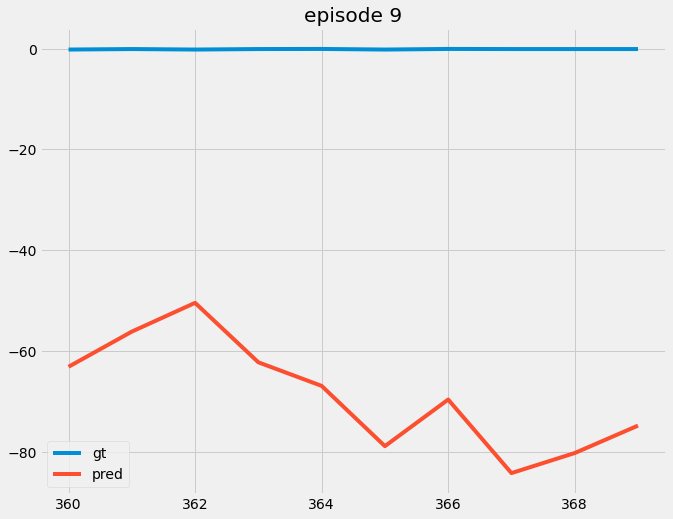

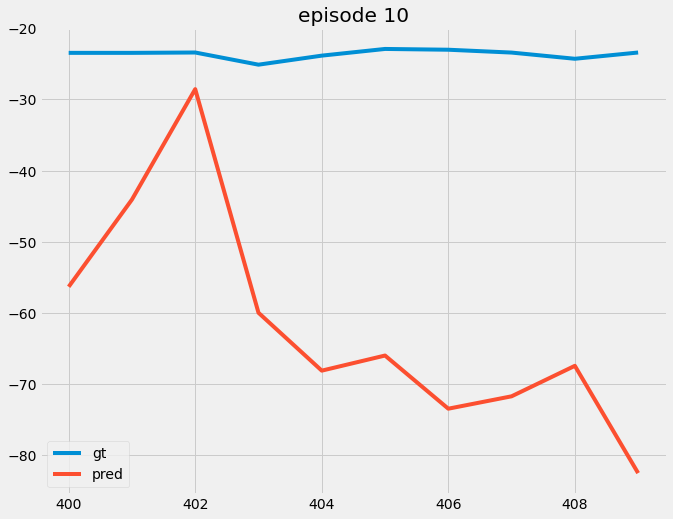

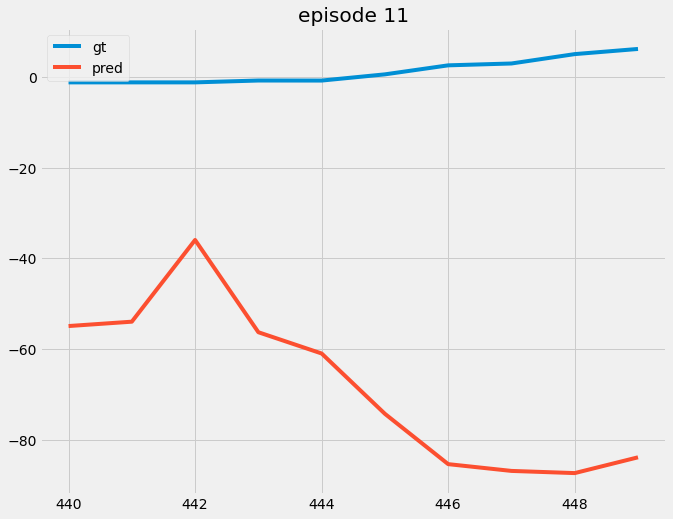

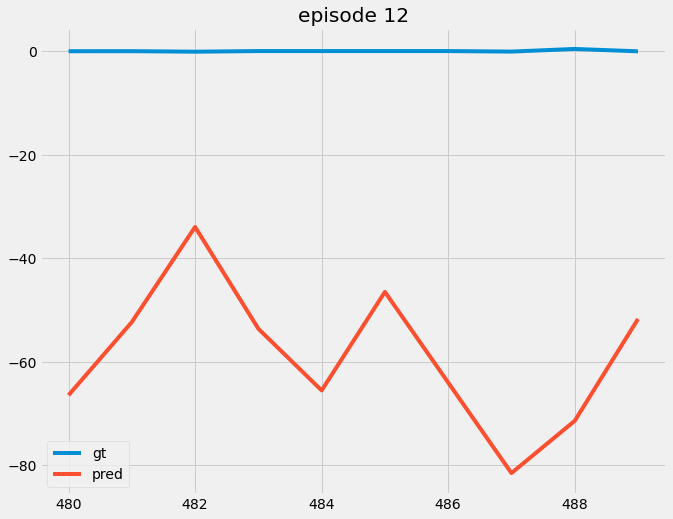

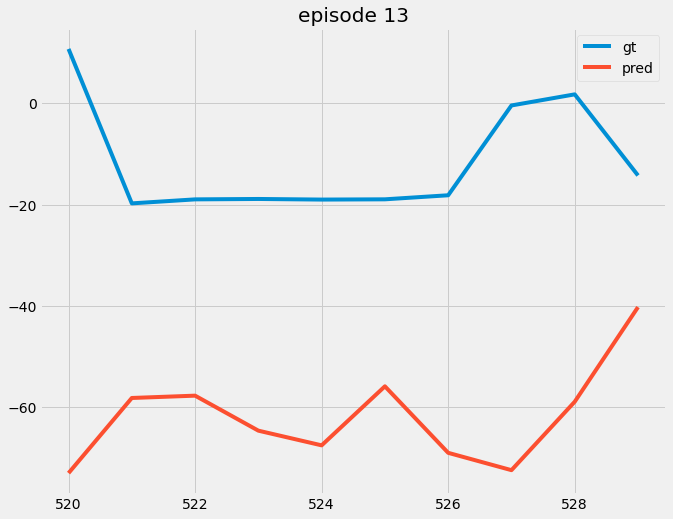

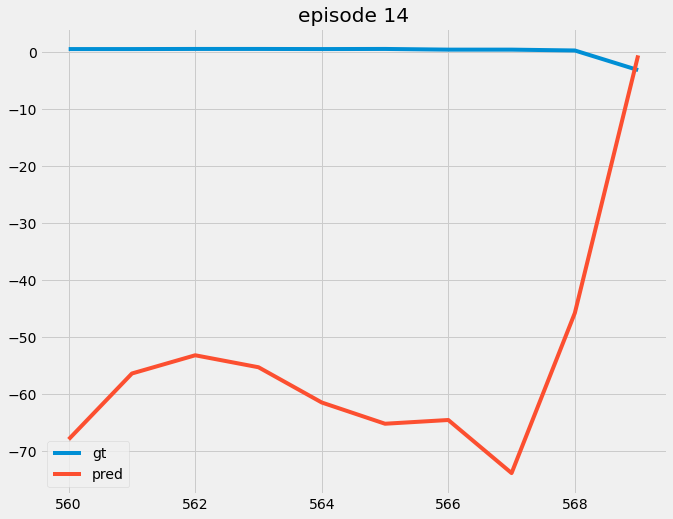

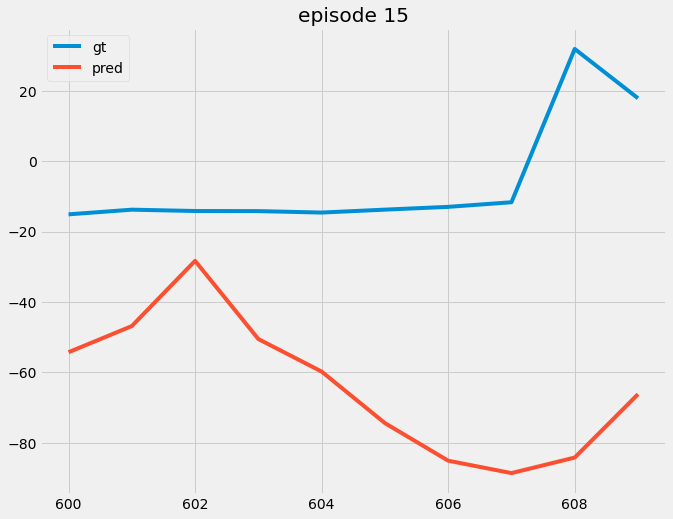

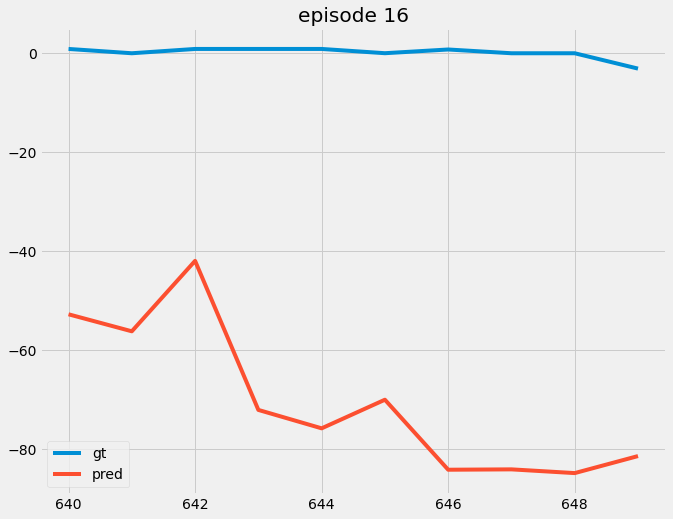

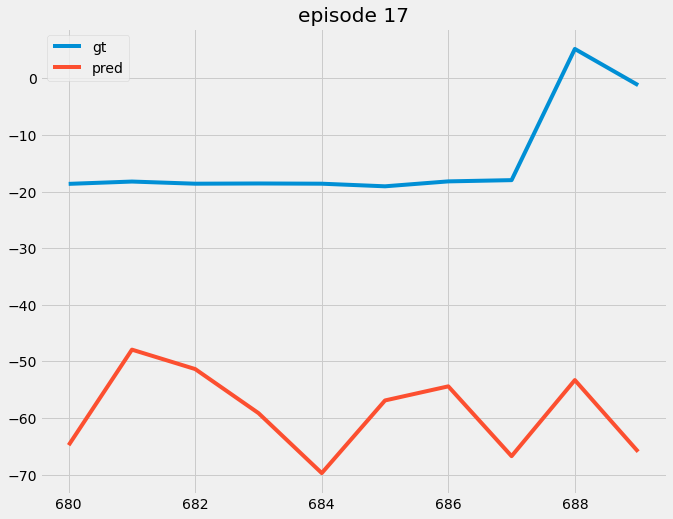

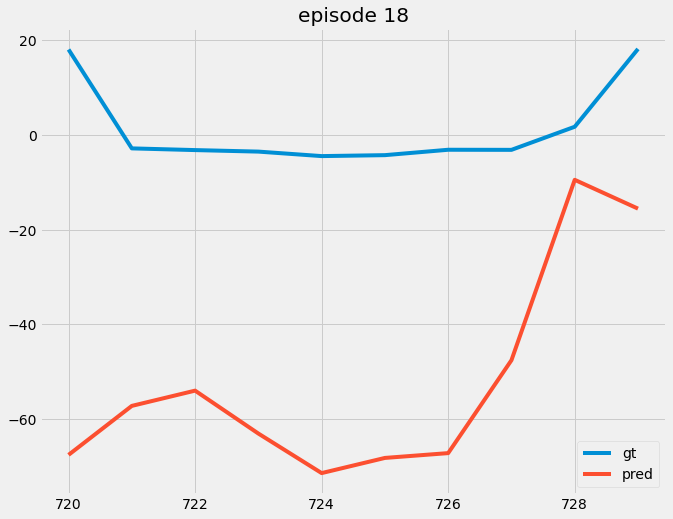

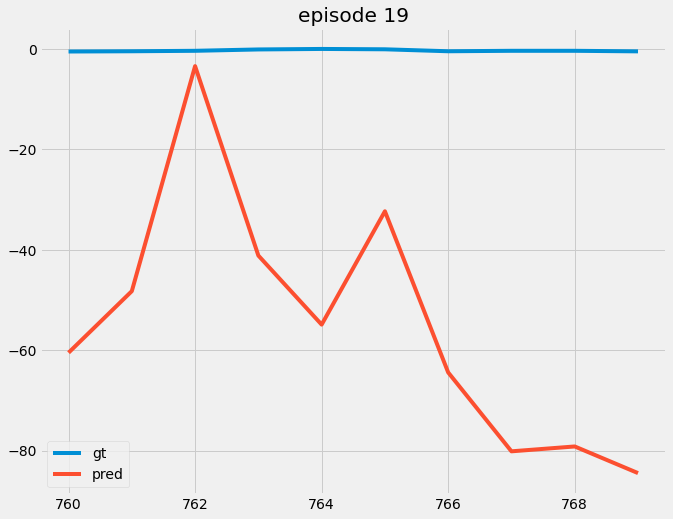

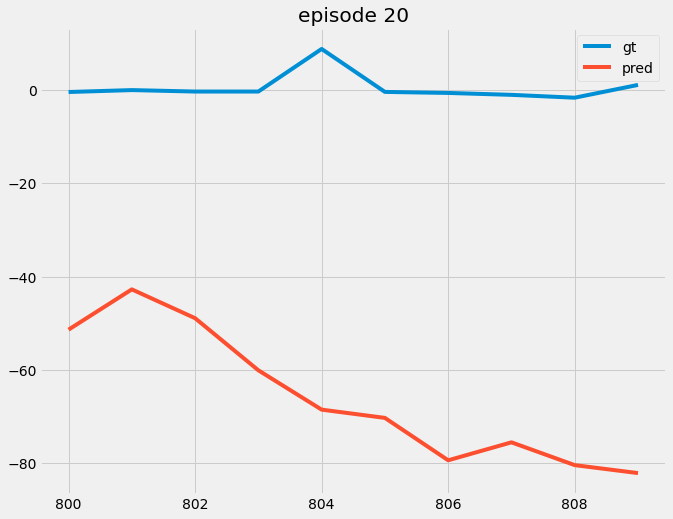

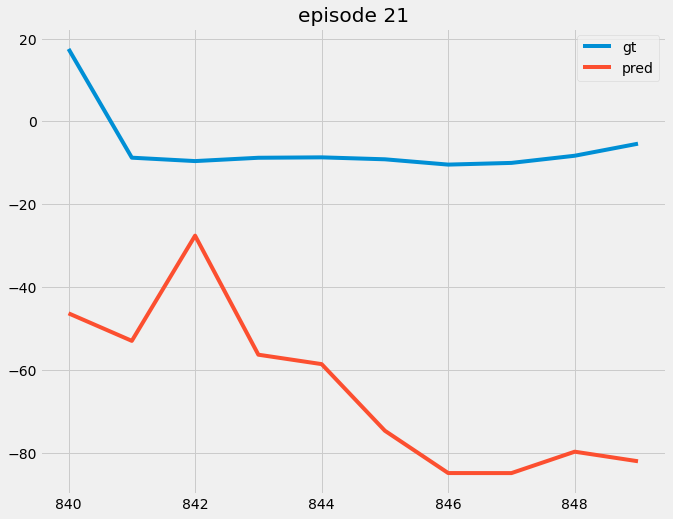

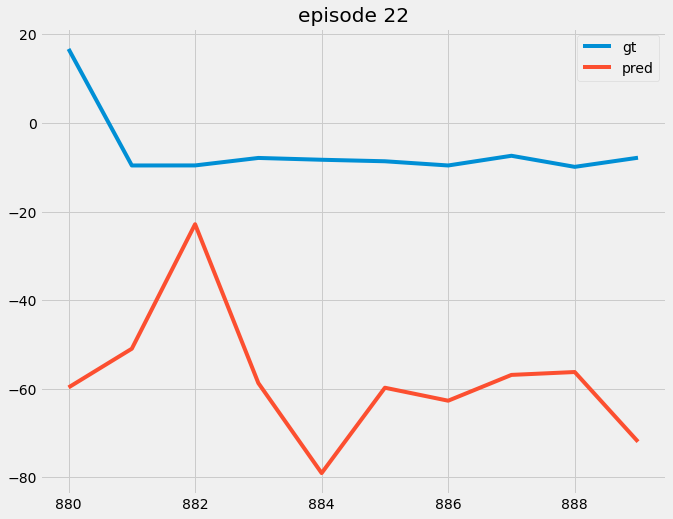

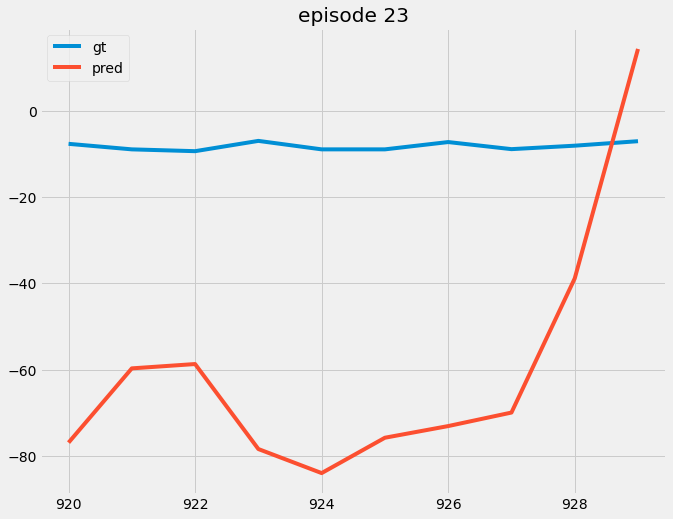

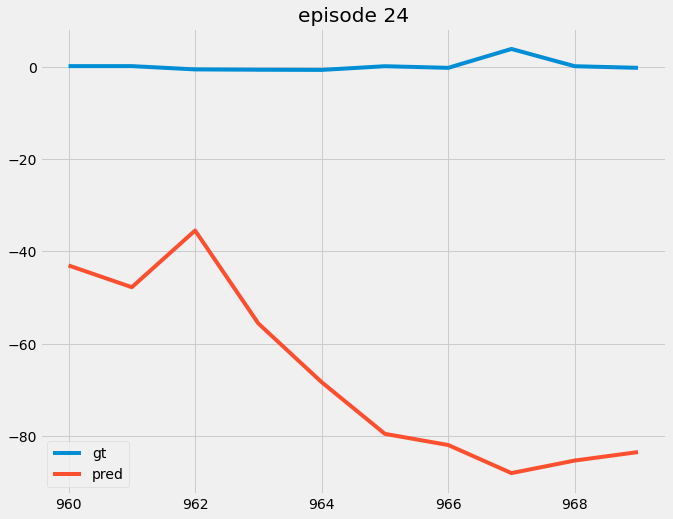

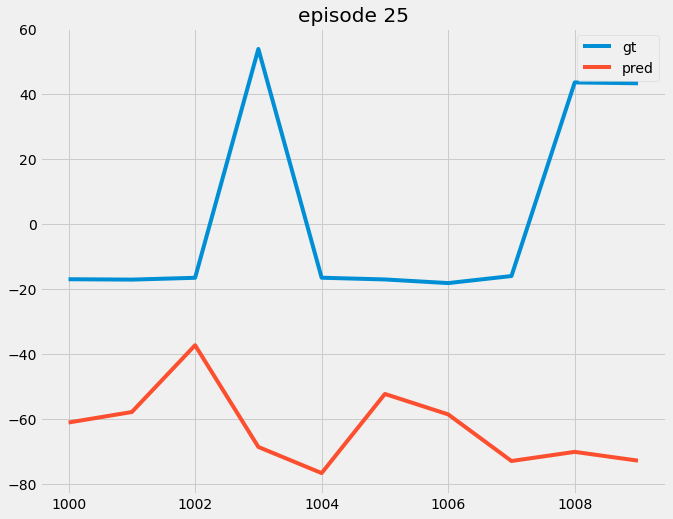

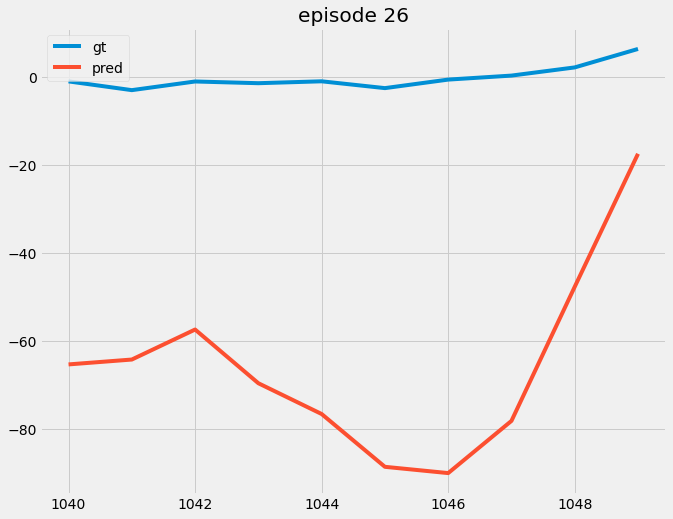

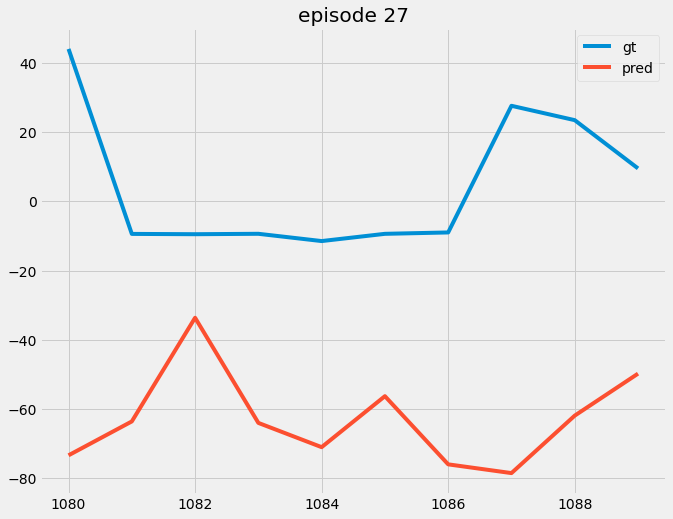

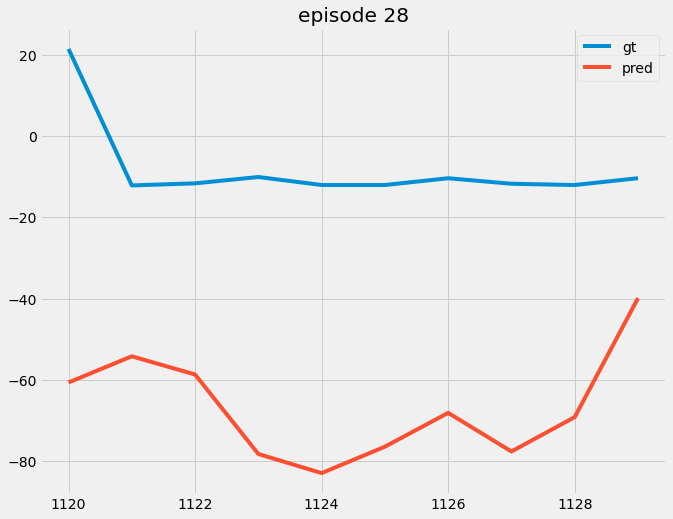

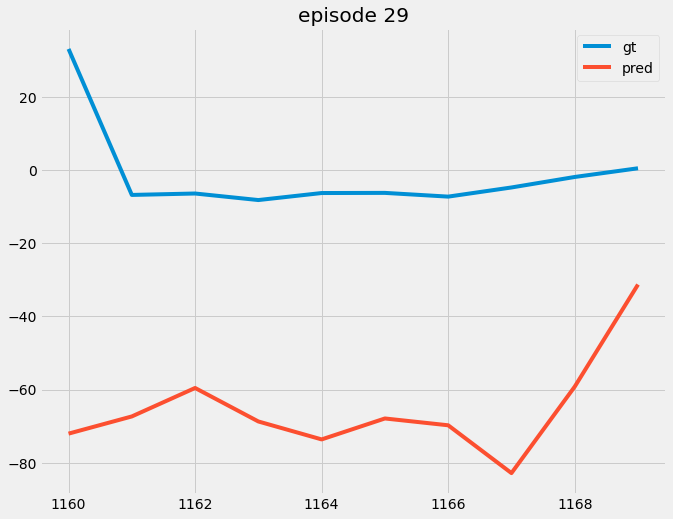

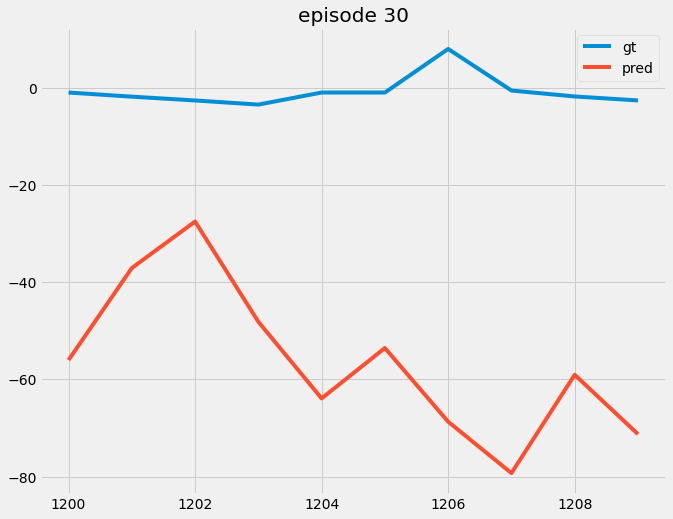

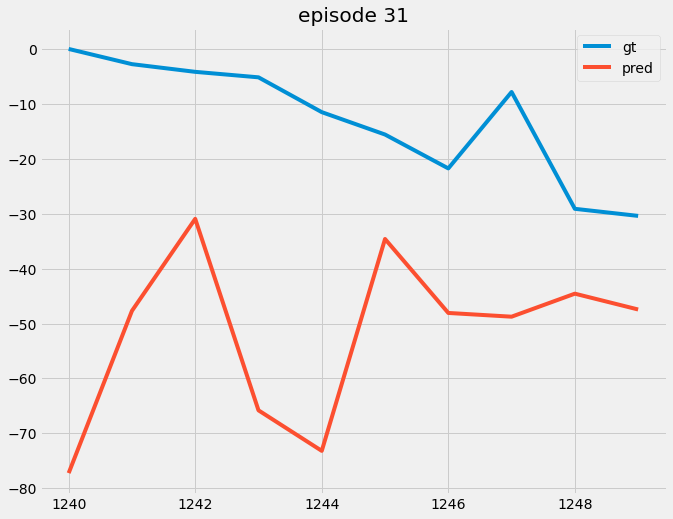

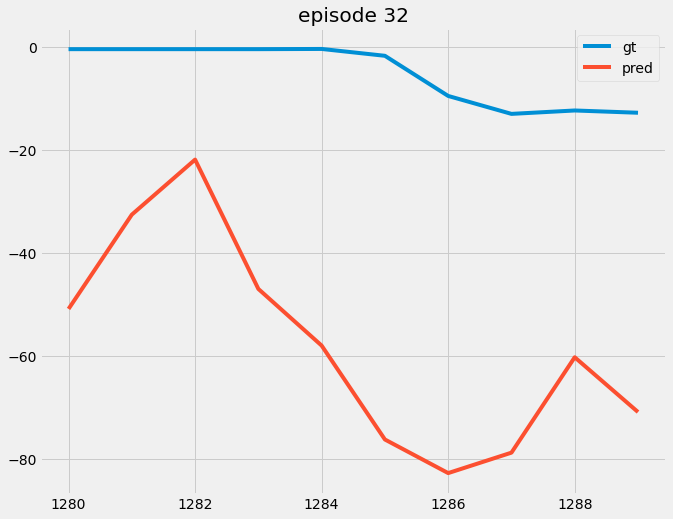

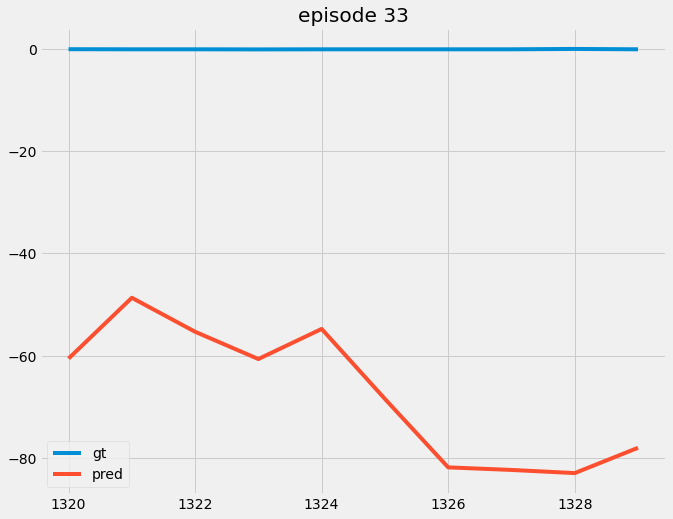

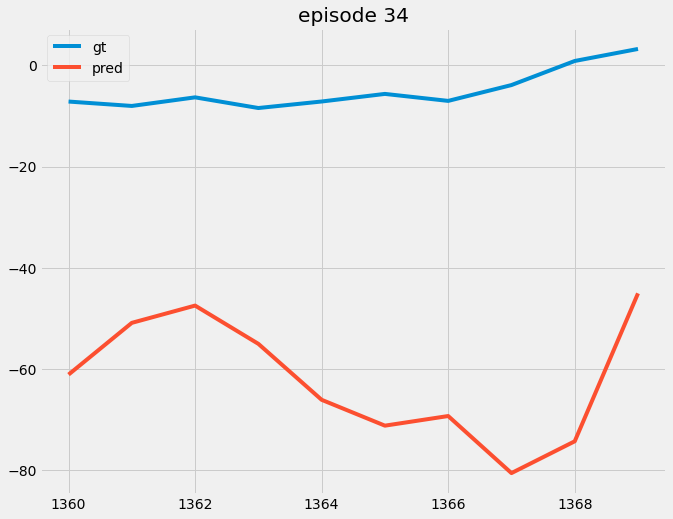

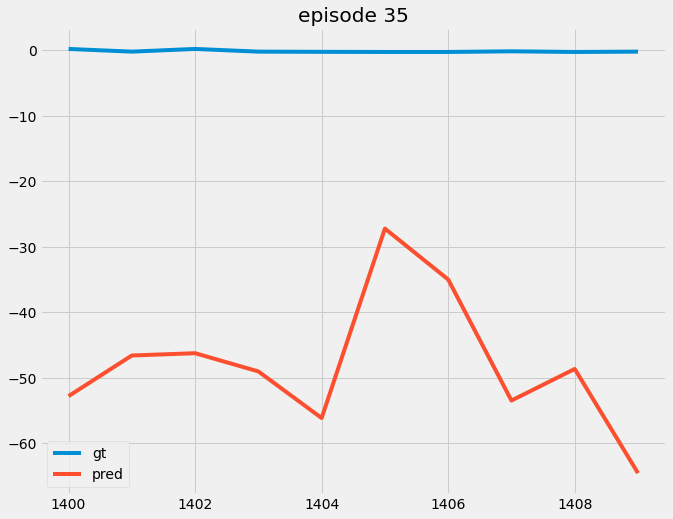

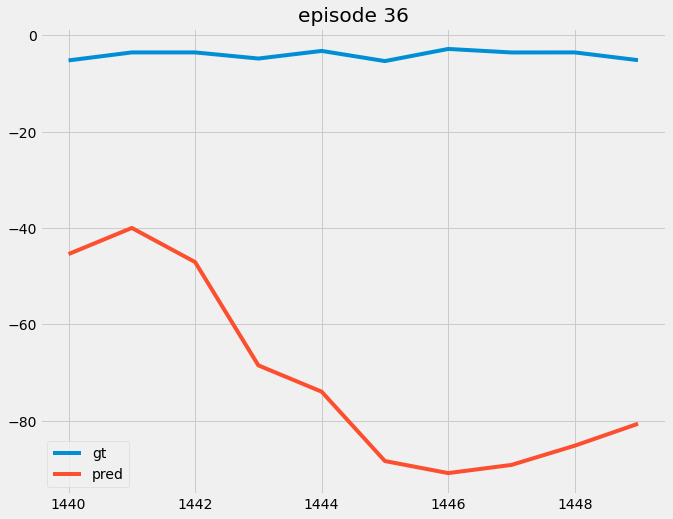

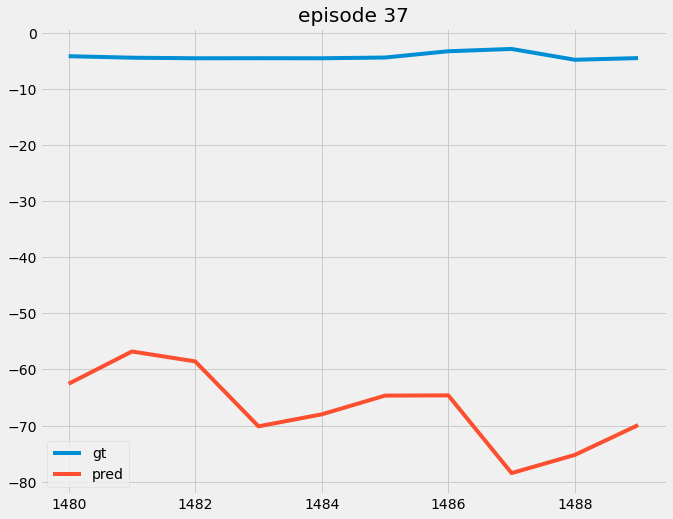

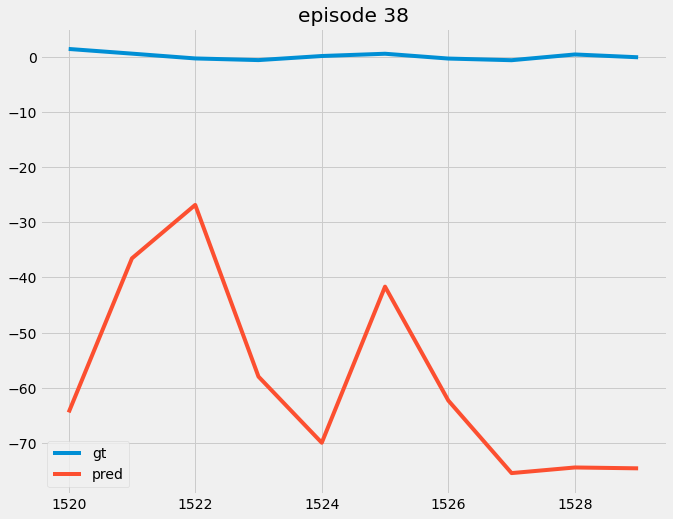

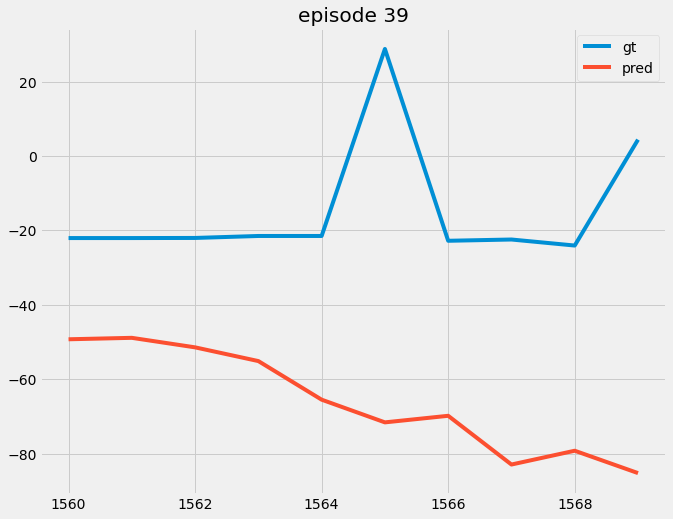

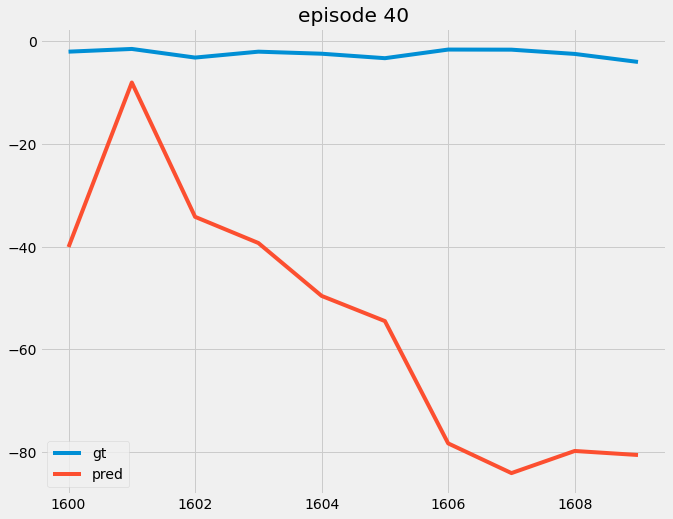

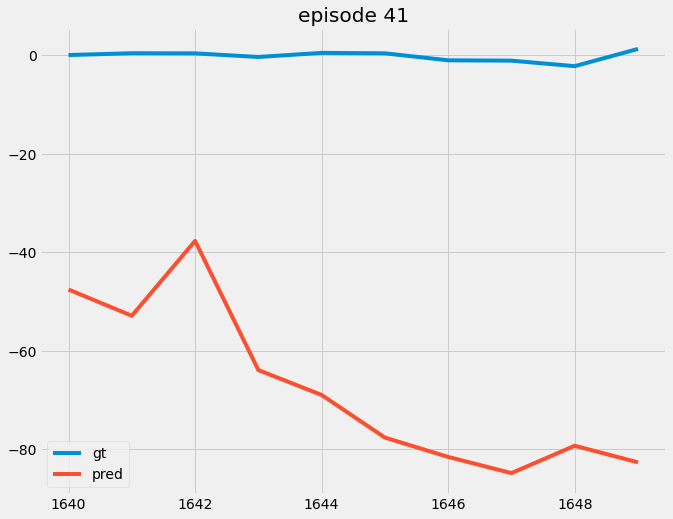

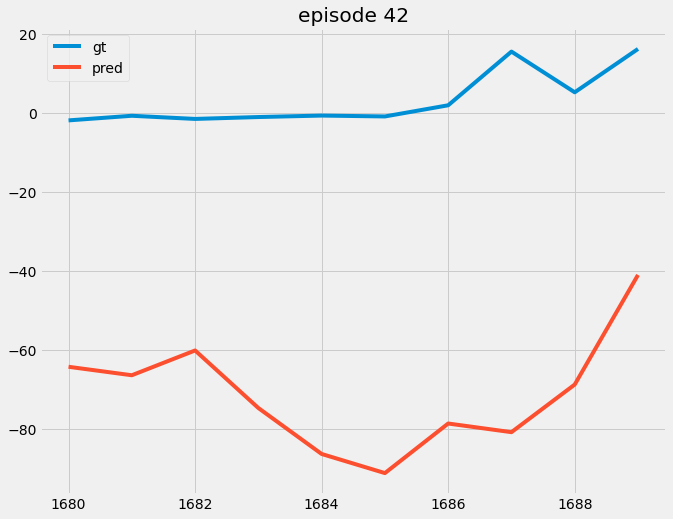

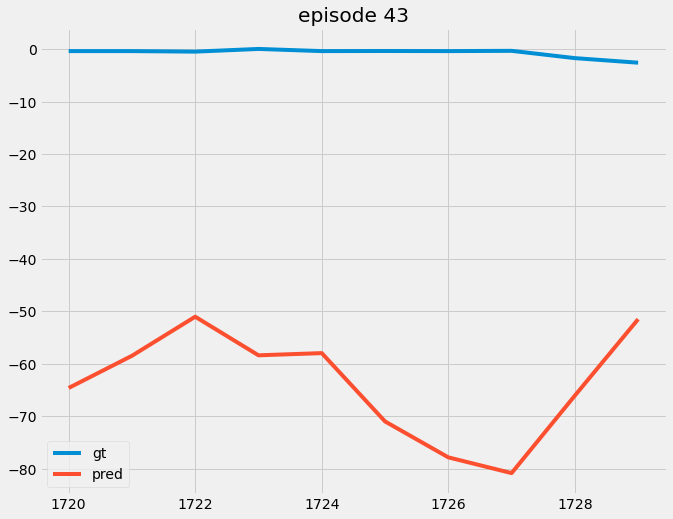

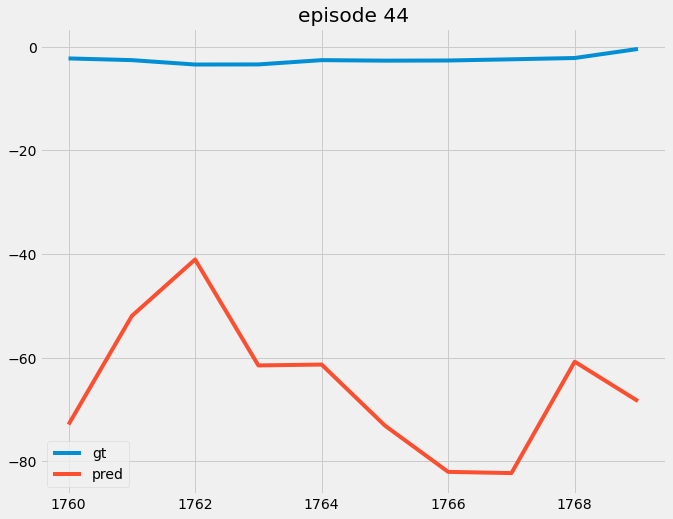

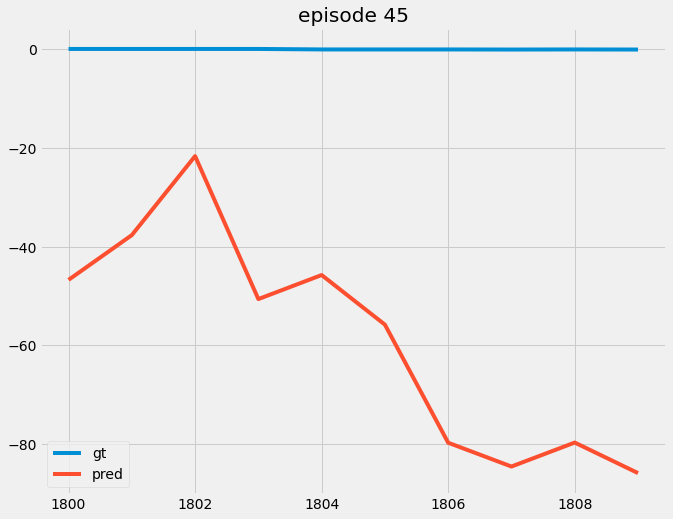

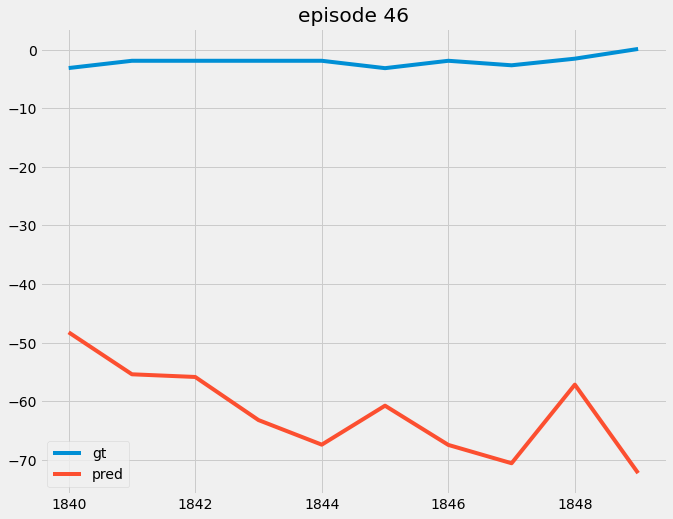

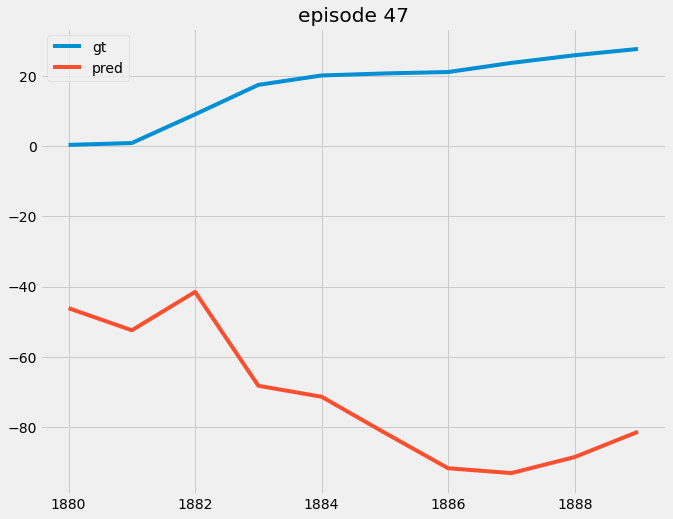

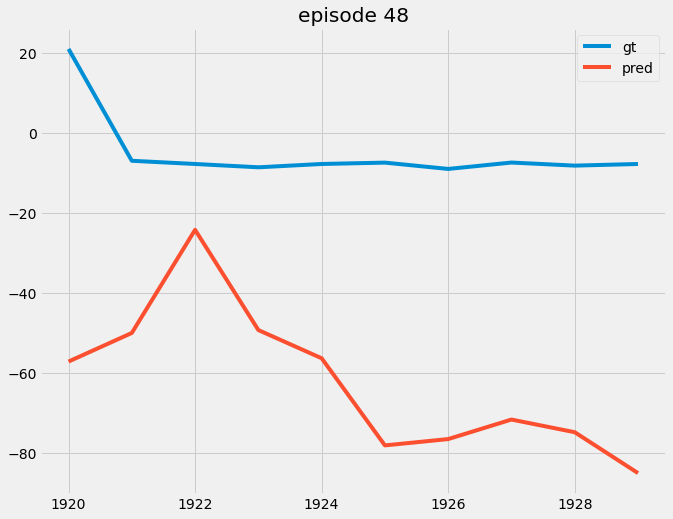

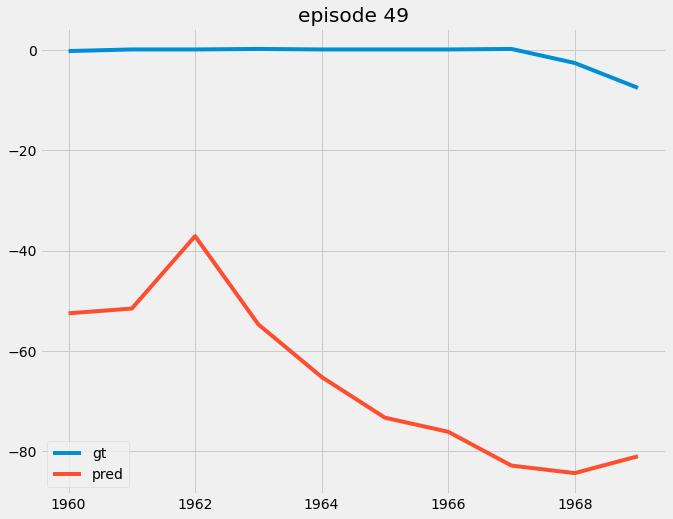

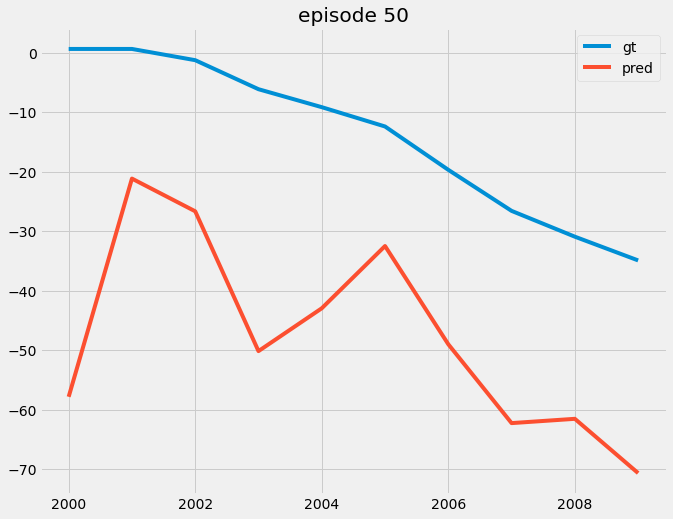

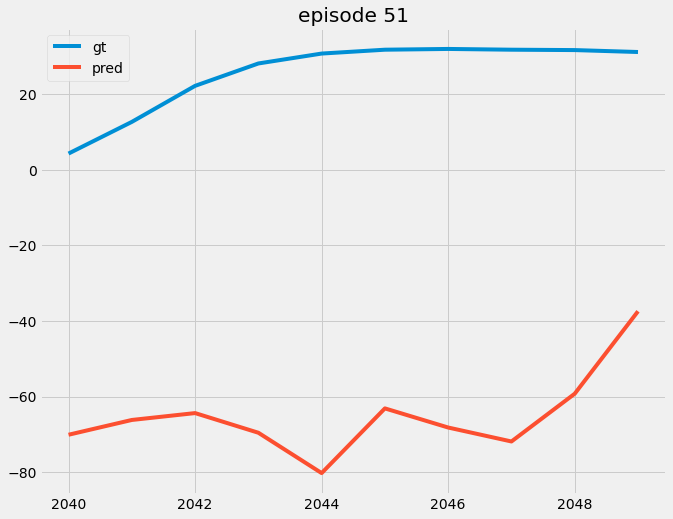

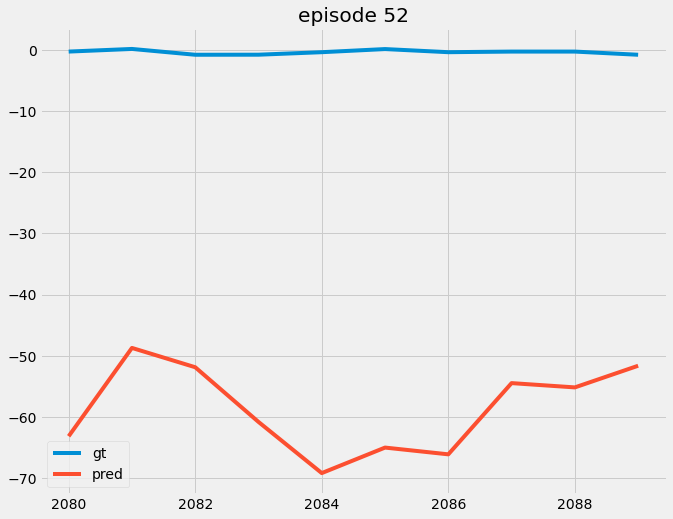

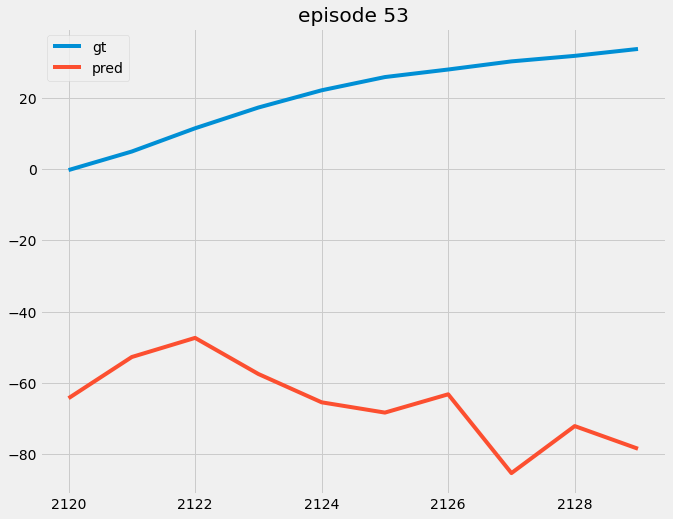

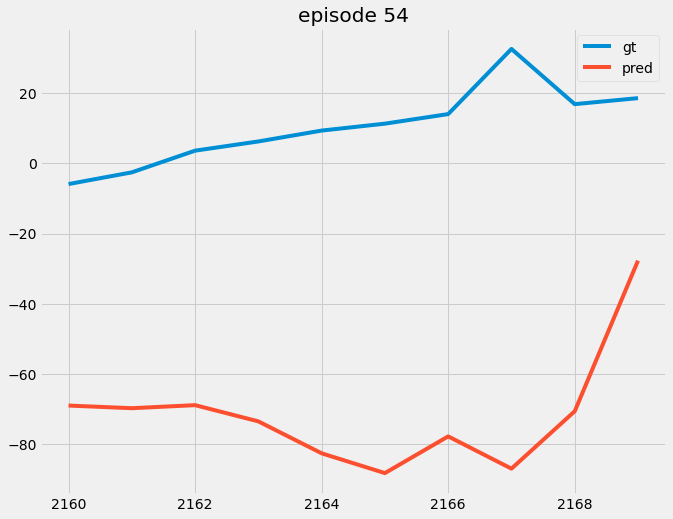

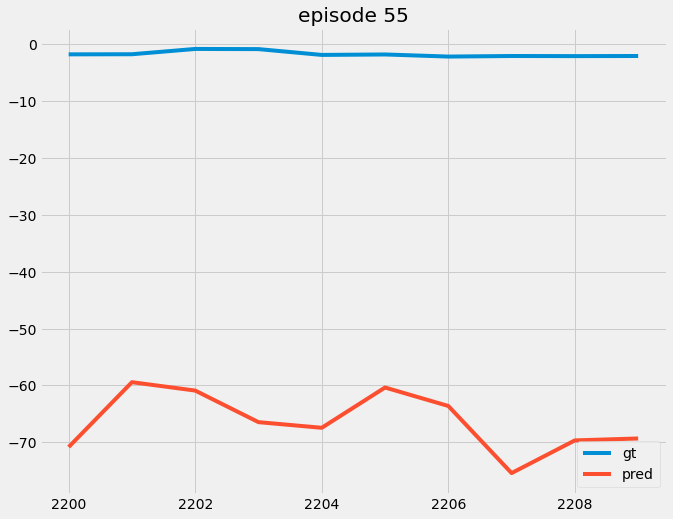

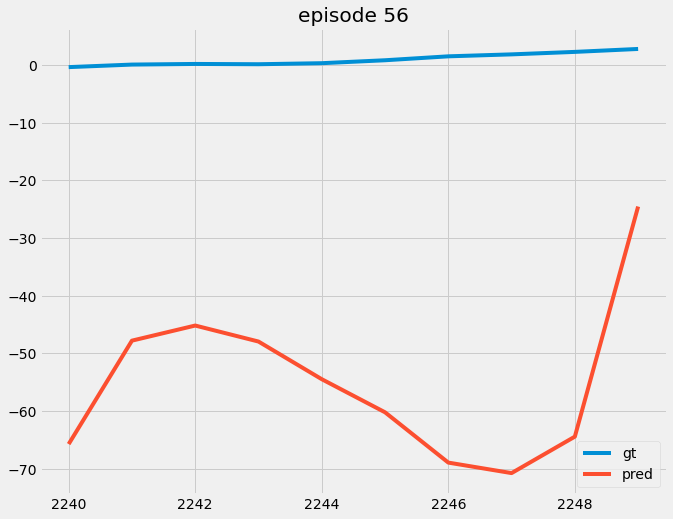

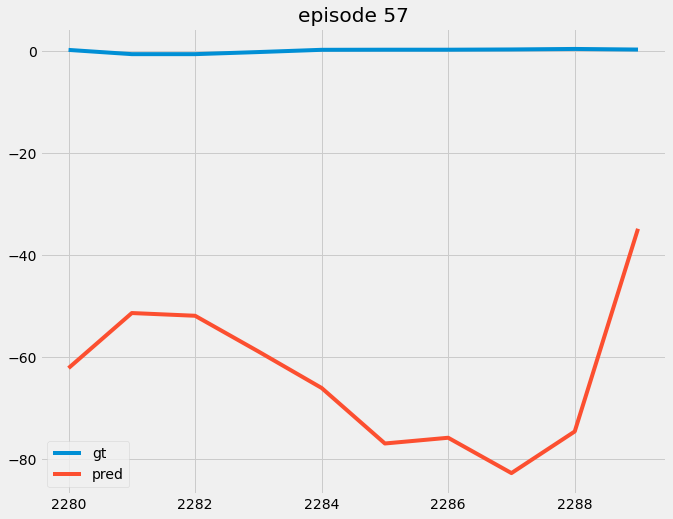

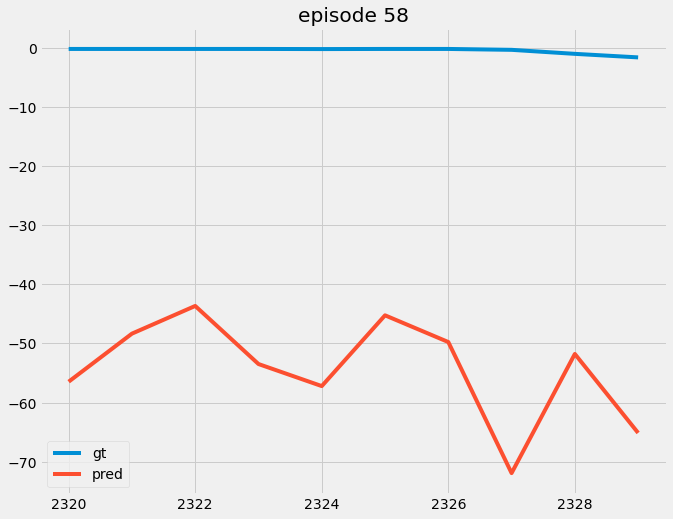

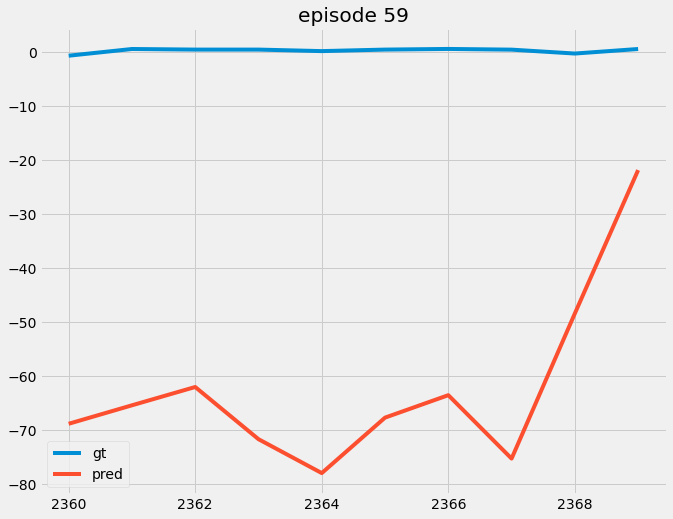

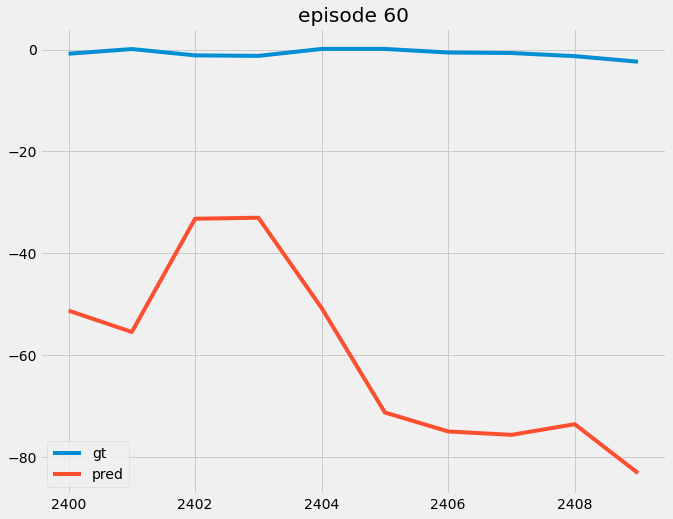

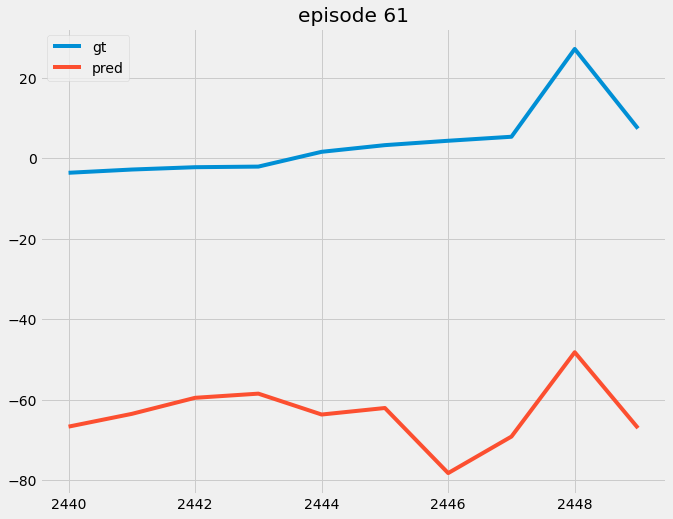

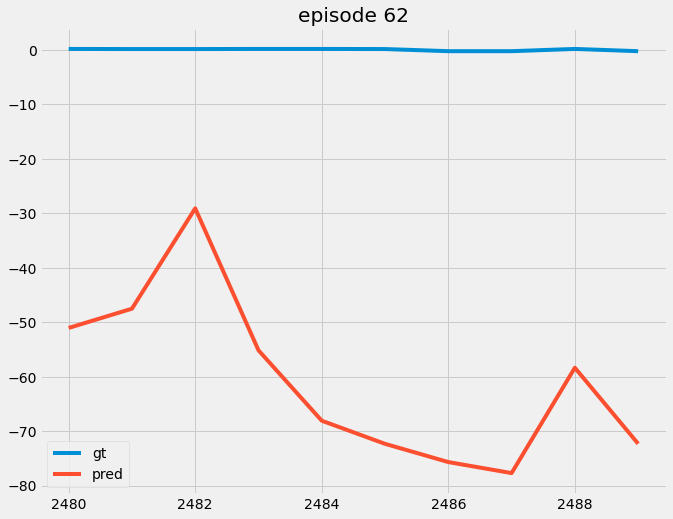

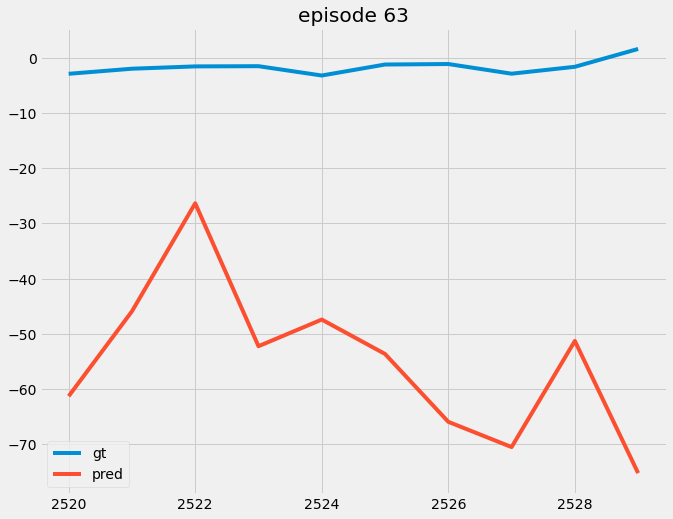

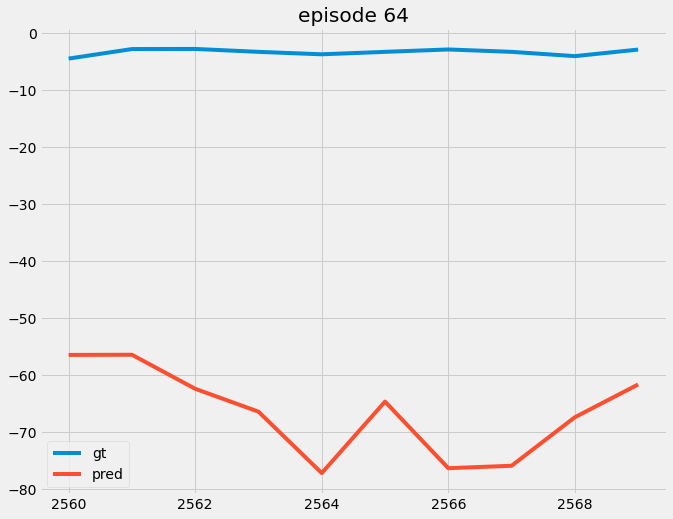

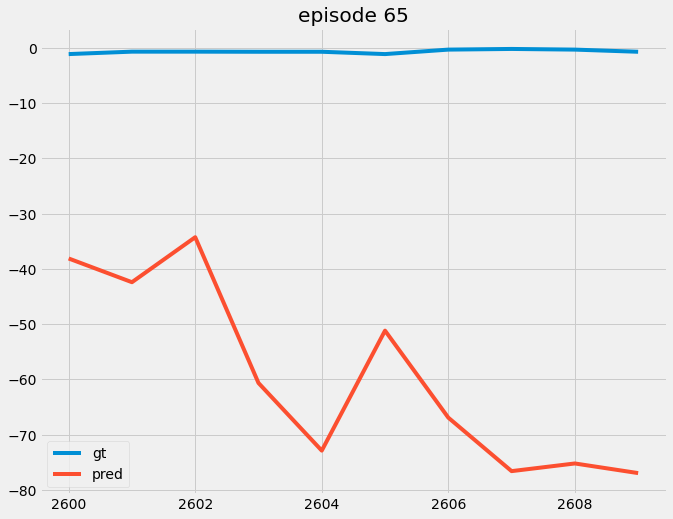

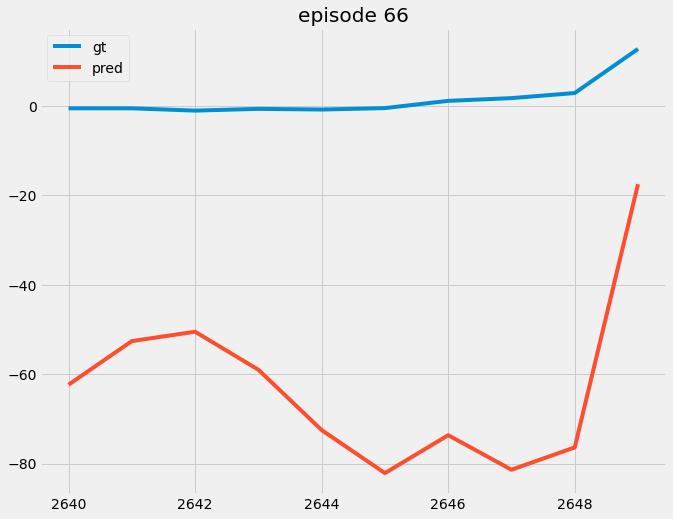

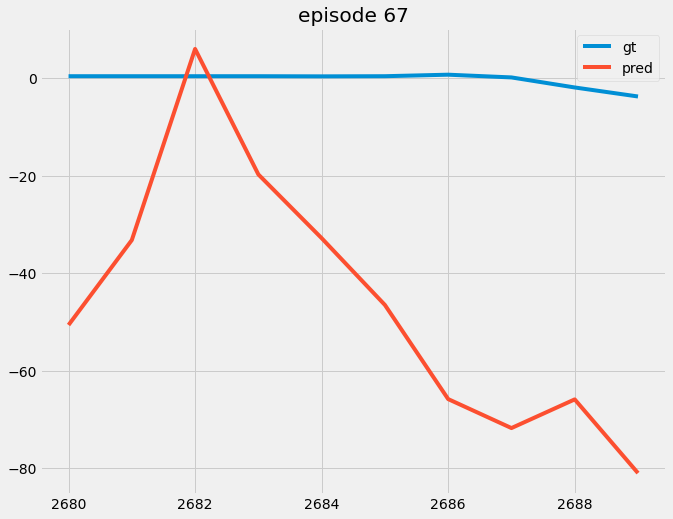

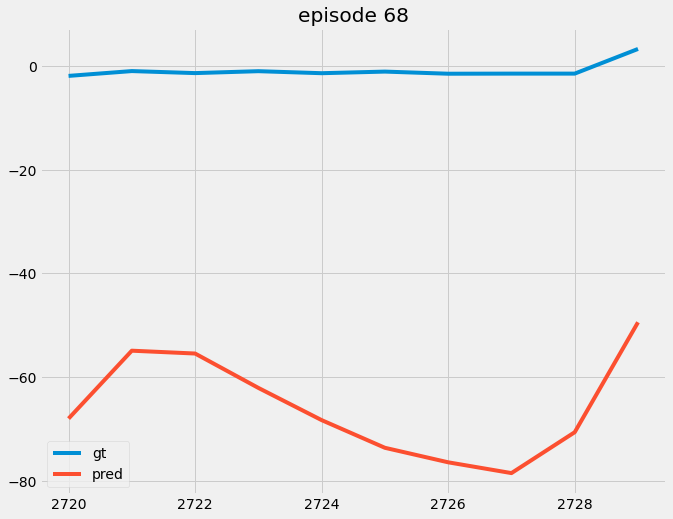

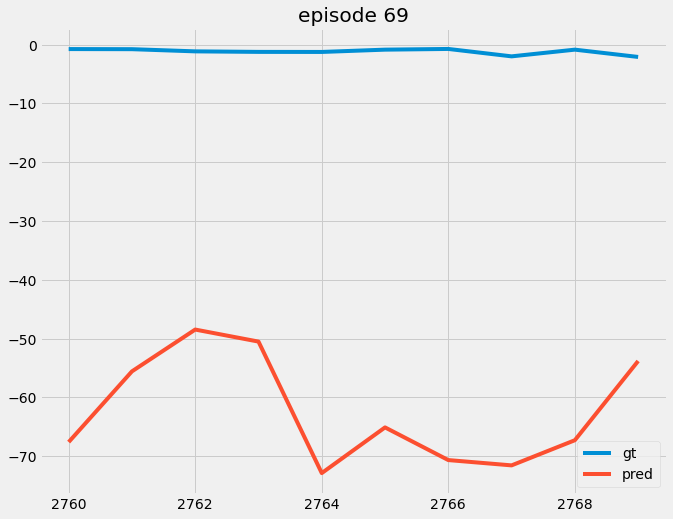

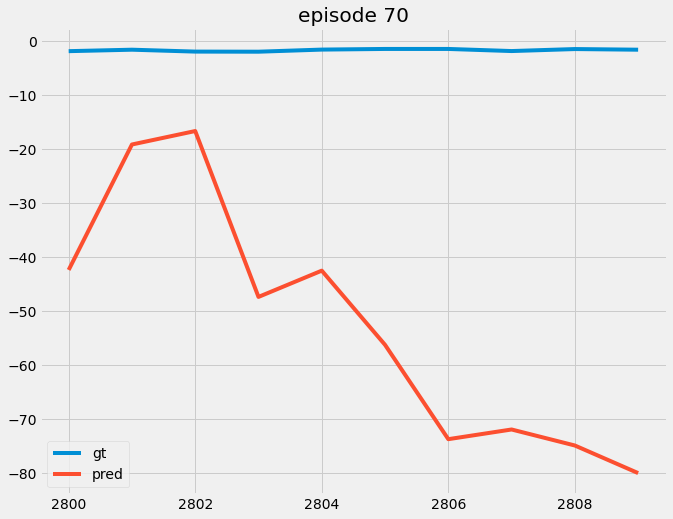

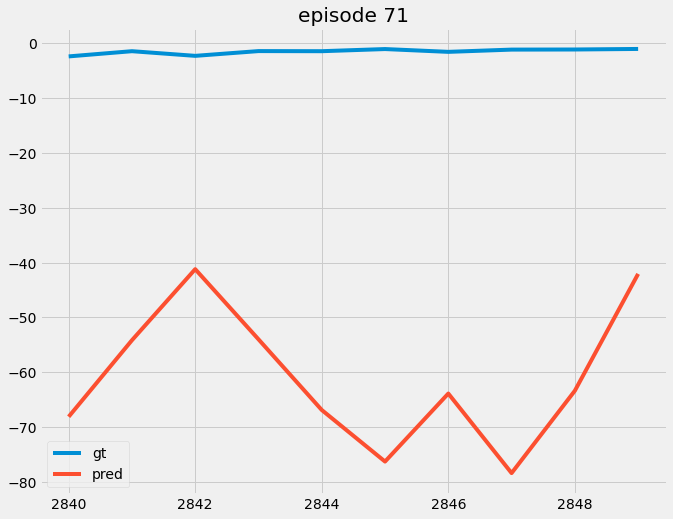

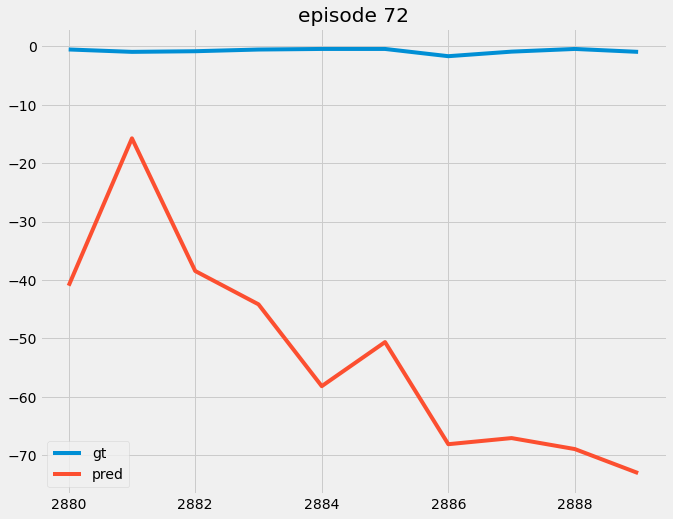

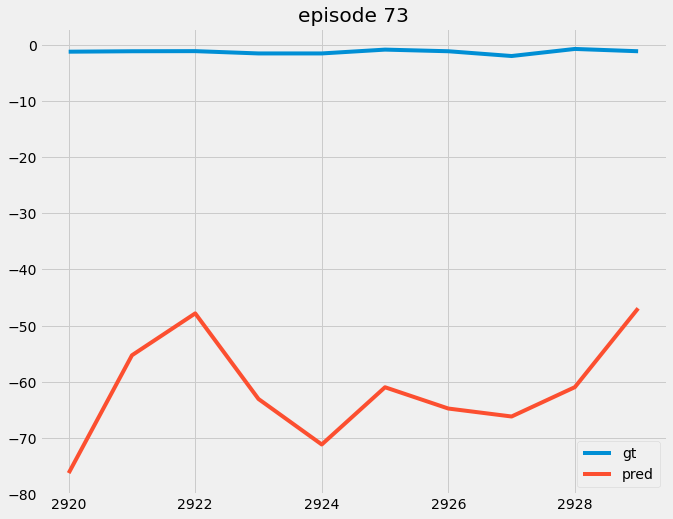

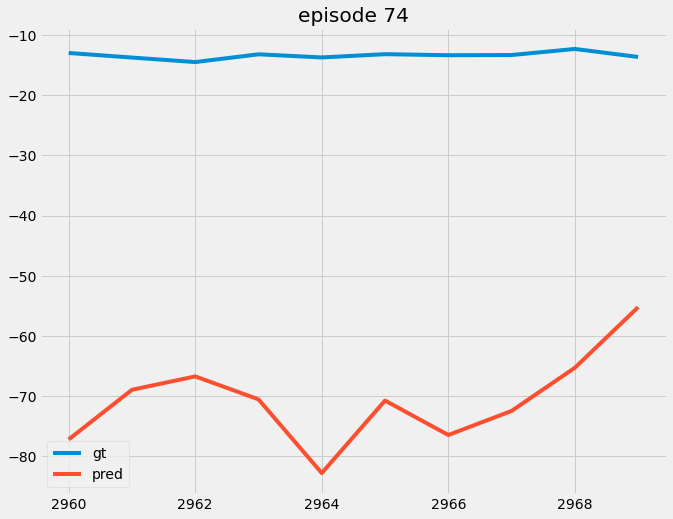

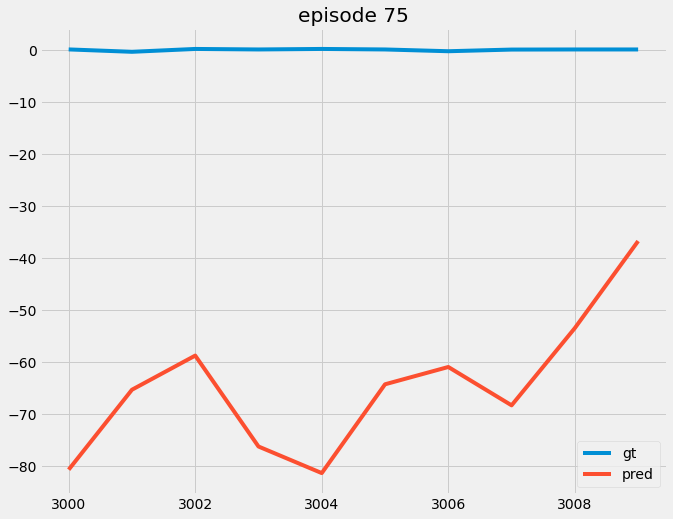

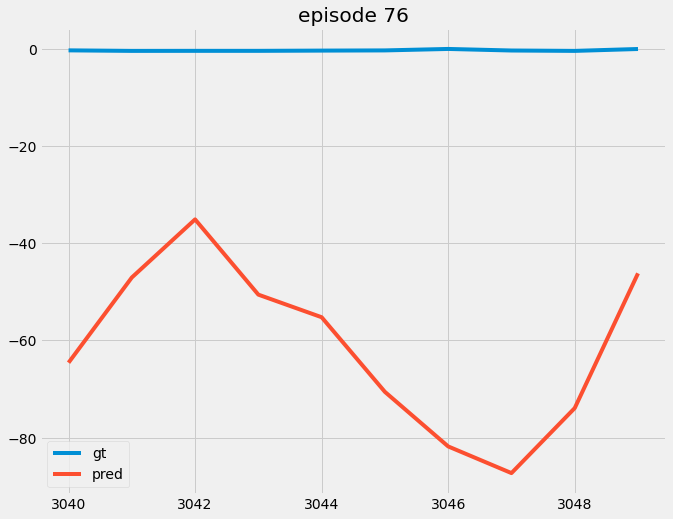

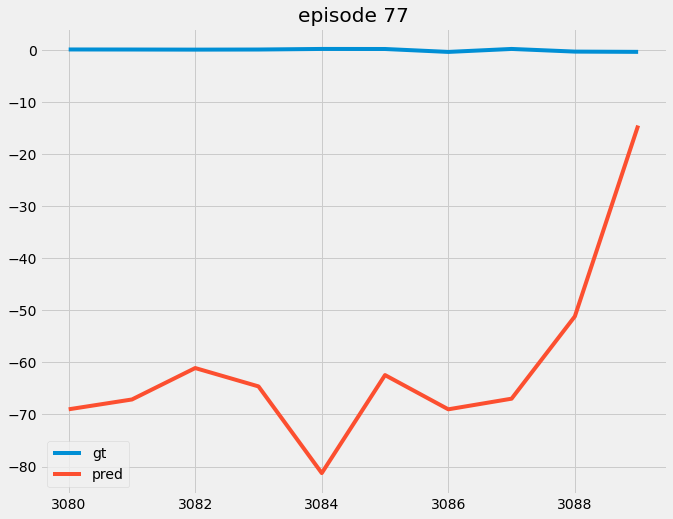

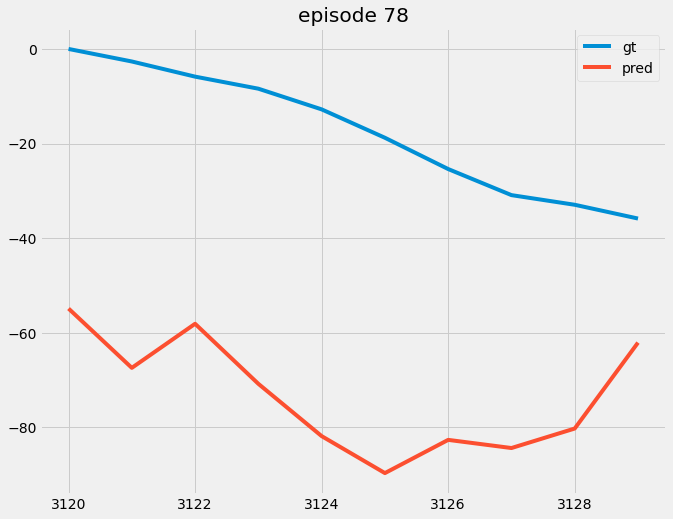

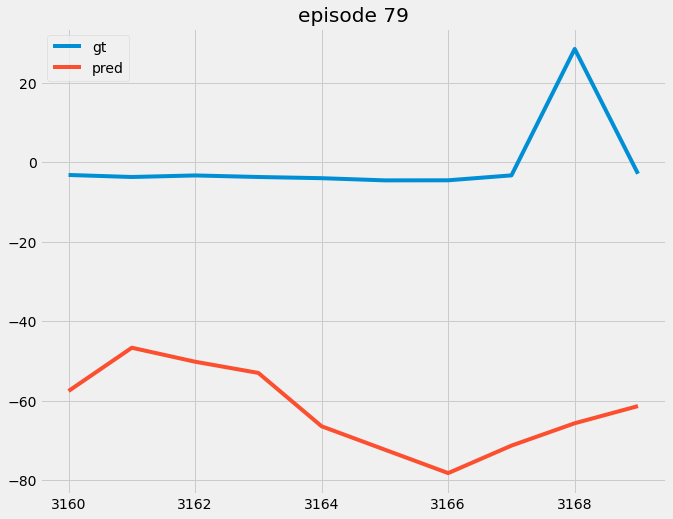

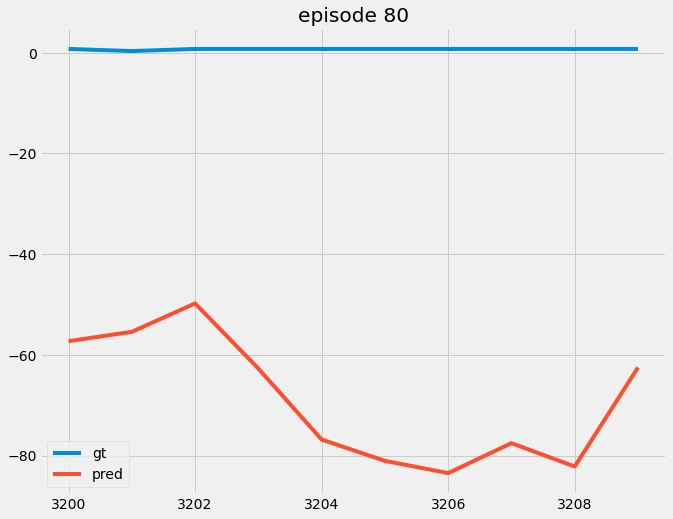

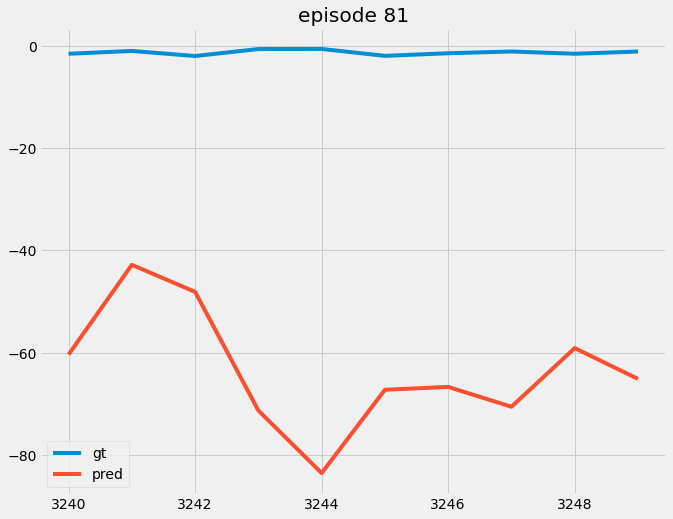

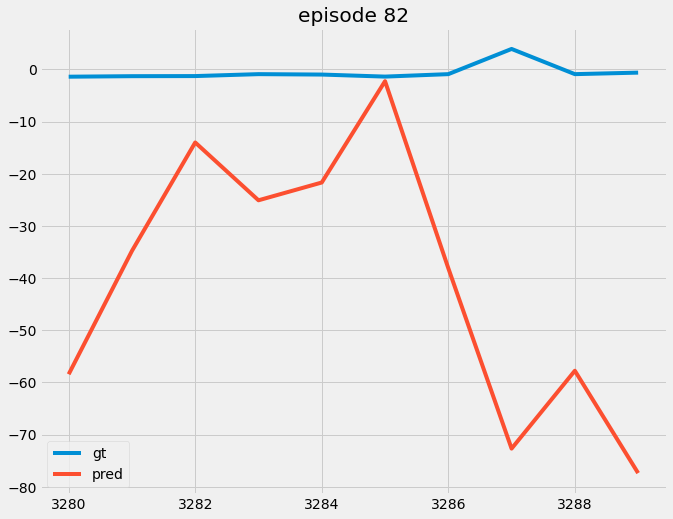

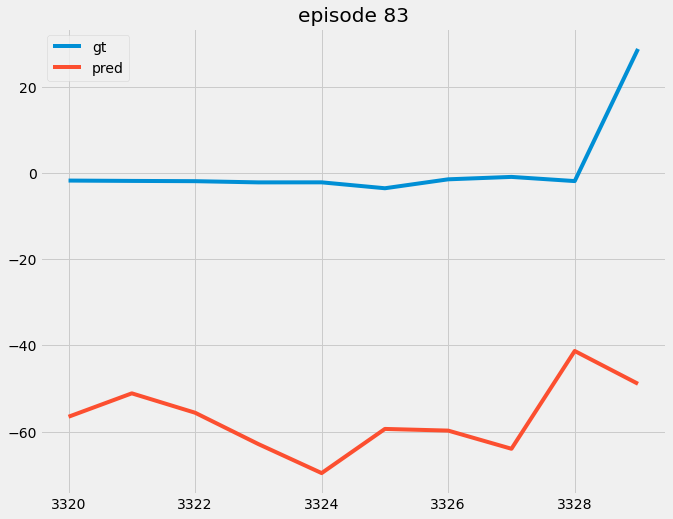

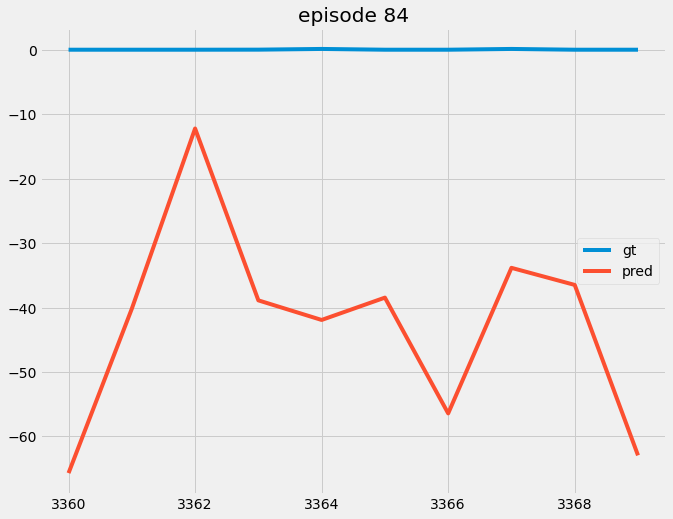

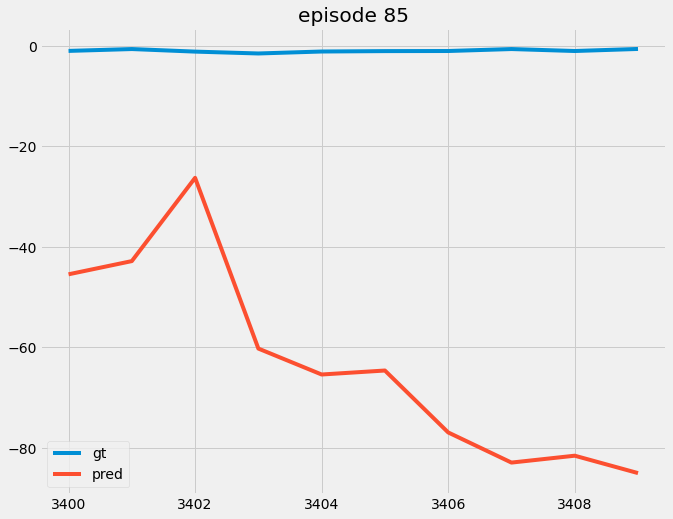

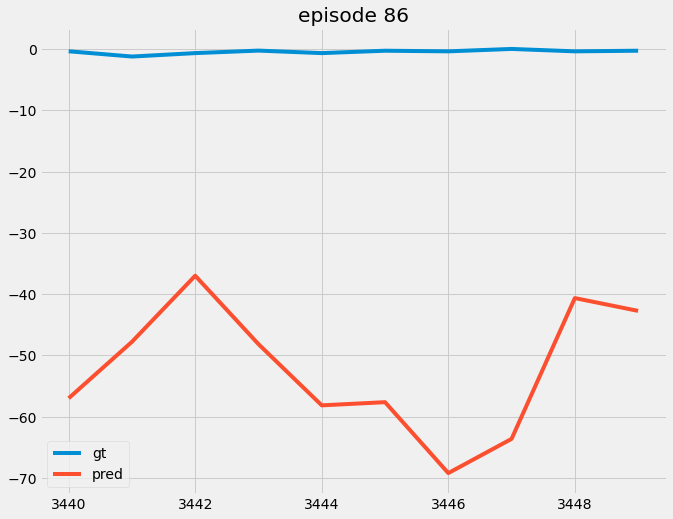

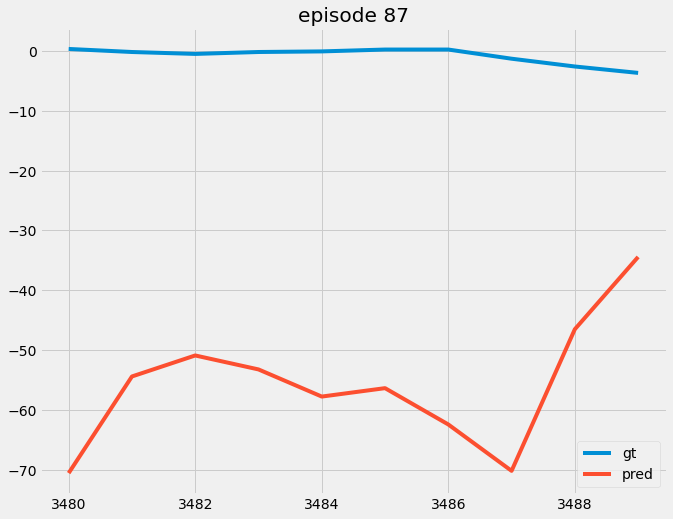

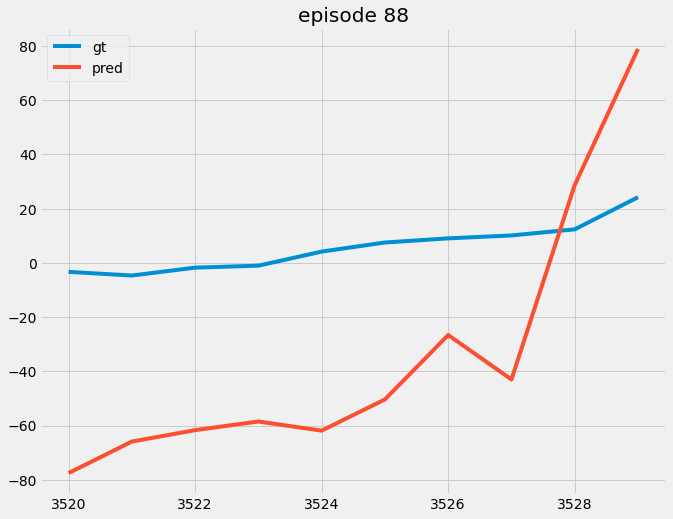

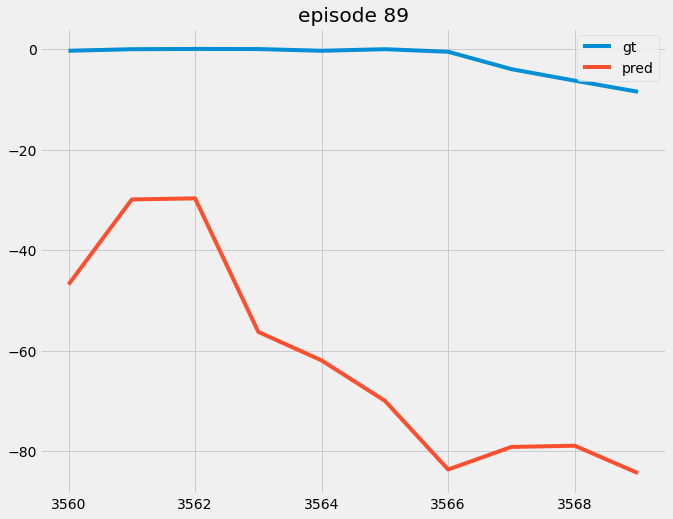

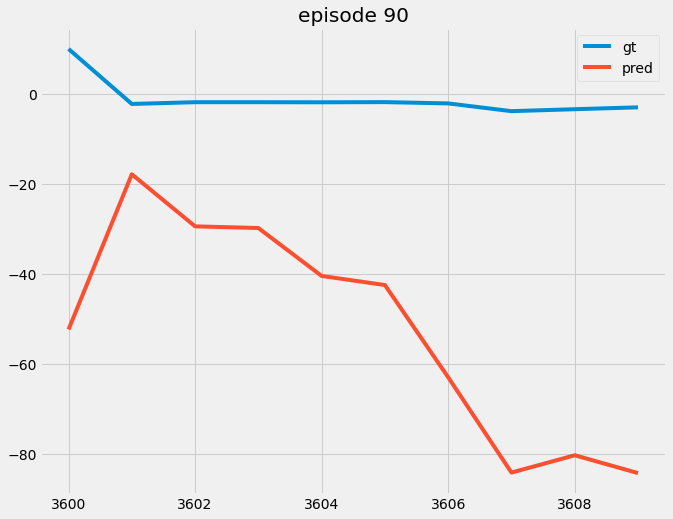

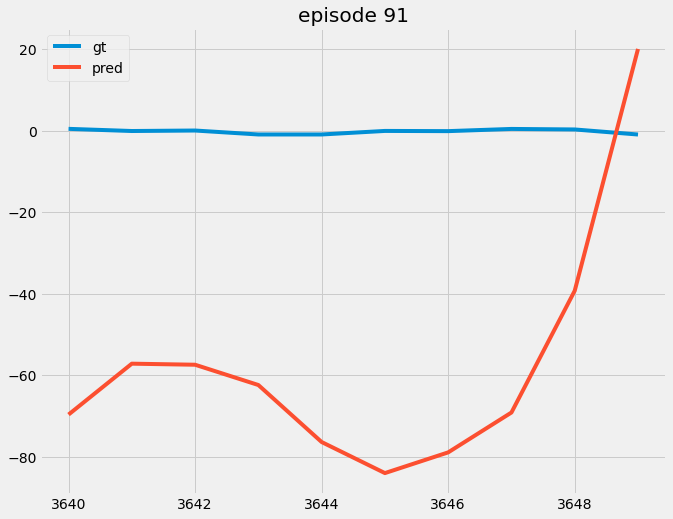

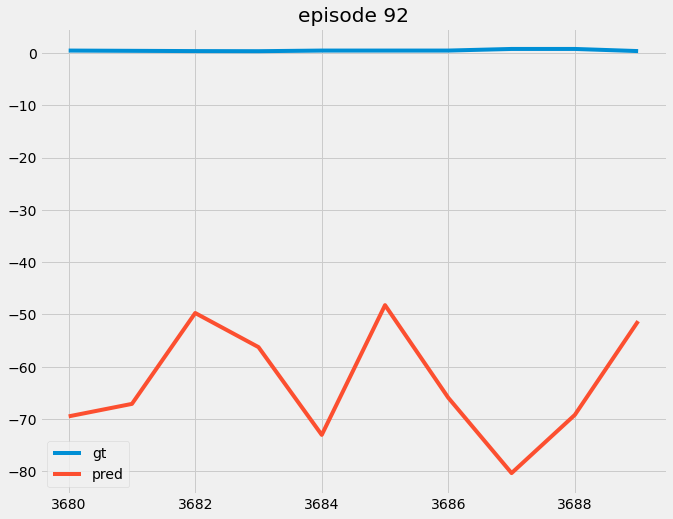

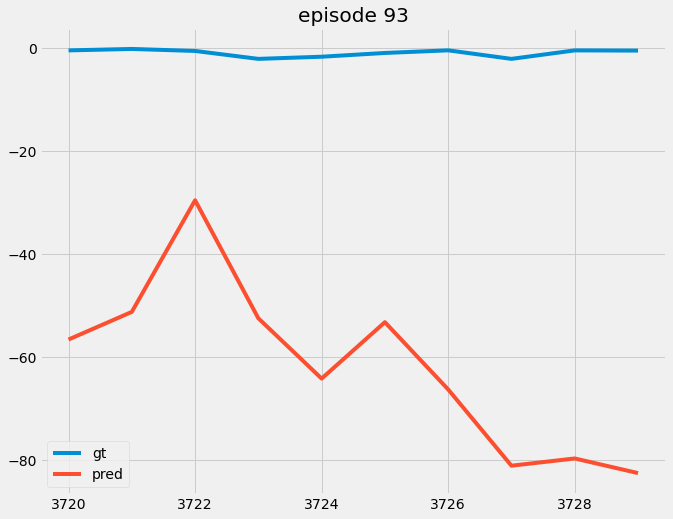

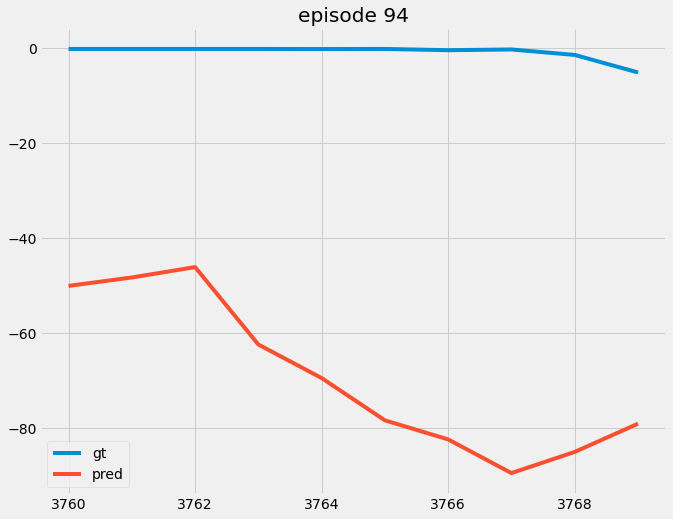

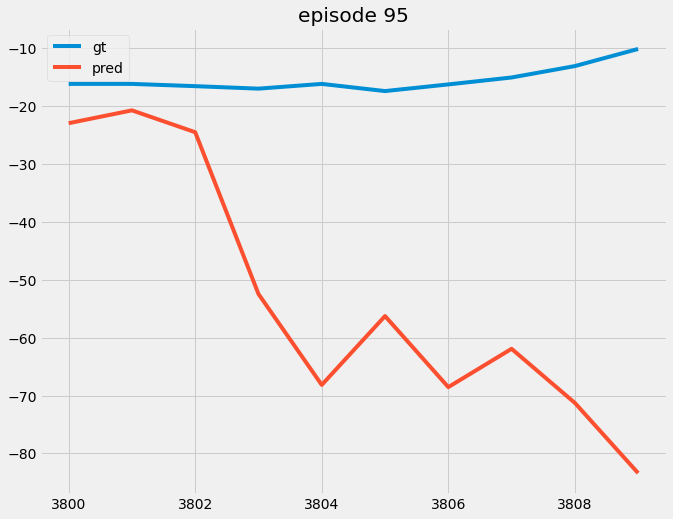

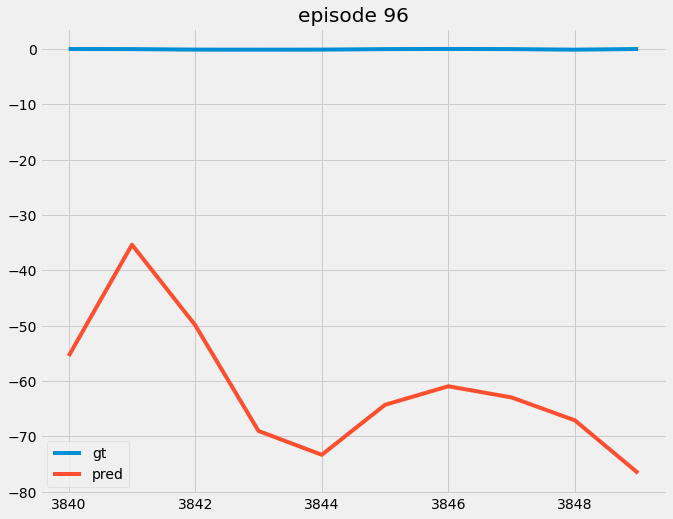

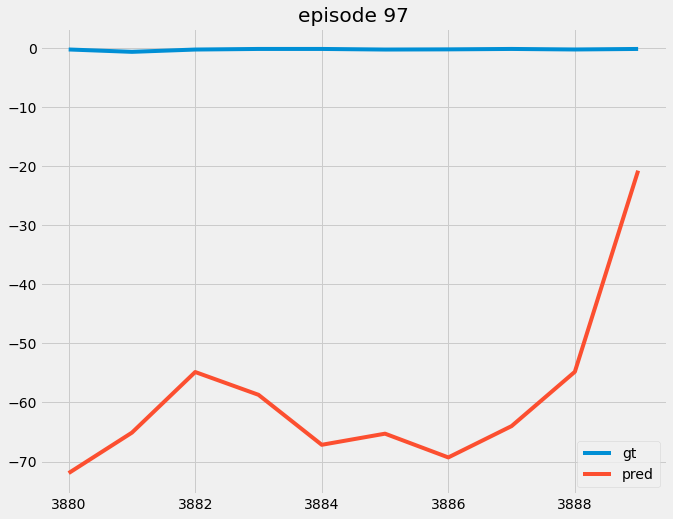

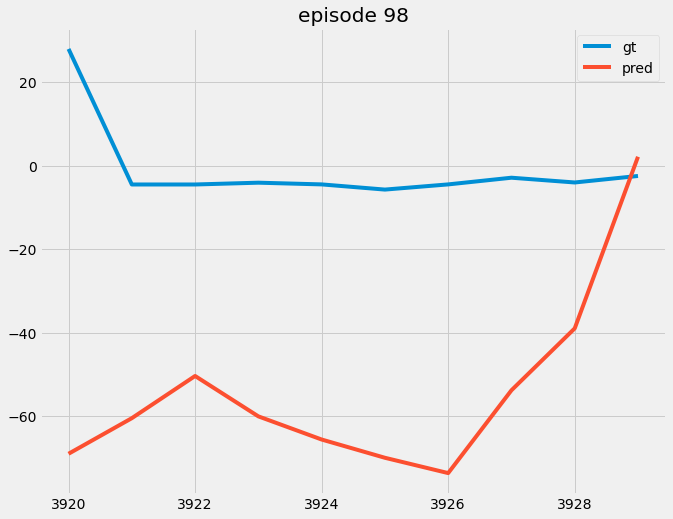

In [ ]:
for episode in range(0,4000-40,40):
    #print(episode)
    vis_ep(episode,episode+10,'episode '+str(episode//40))

In [ ]:
finaldf['travel_dist'][40:80],Y[40:80]

(0      0.0072
 1     -0.4328
 2      0.0272
 3     -0.4328
 4     -0.4228
 5     -0.4228
 6     -0.4728
 7     -0.1628
 8      0.4172
 9     -0.7228
 10    -0.4728
 11    -1.2828
 12    -0.4228
 13    -0.6028
 14    -0.7728
 15     0.3072
 16    -0.4028
 17    -0.6528
 18    -1.4228
 19    -3.1728
 20    -6.9628
 21   -12.4028
 22   -13.1228
 23   -13.8528
 24   -14.9728
 25   -17.9928
 26   -20.3128
 27   -23.6028
 28   -25.9528
 29   -29.8428
 30   -34.3128
 31   -36.9228
 32   -37.9228
 33   -41.6828
 34   -43.3928
 35   -43.9728
 36   -45.8728
 37   -47.0828
 38   -48.5628
 39   -51.1428
 Name: travel_dist, dtype: float64,     travel_dist
 0        0.0072
 1       -0.4328
 2        0.0272
 3       -0.4328
 4       -0.4228
 5       -0.4228
 6       -0.4728
 7       -0.1628
 8        0.4172
 9       -0.7228
 10      -0.4728
 11      -1.2828
 12      -0.4228
 13      -0.6028
 14      -0.7728
 15       0.3072
 16      -0.4028
 17      -0.6528
 18      -1.4228
 19      -3.1728
 20     